In [1]:
! pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib
! pip install -U ipywidgets
! pip install numpy==1.26.4
! pip install urllib3==1.26.6

In [2]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, Union, Callable


import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader
from flwr.server.strategy import Strategy
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context, Status, GetParametersRes, Parameters, GetParametersIns, MetricsAggregationFn,NDArrays,Scalar
from flwr.server import ServerApp, ServerConfig, ServerAppComponents 
from flwr.server.strategy import FedAvg, FedProx
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.15.2 / PyTorch 2.6.0


In [3]:

BATCH_SIZE = 32

def load_datasets(partition_id, num_partitions: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": num_partitions})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train_test["train"], batch_size=32, shuffle=True)
    valloader = DataLoader(partition_train_test["test"], batch_size=32)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=32)
    return trainloader, valloader, testloader

In [4]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class MoonNet(nn.Module):
    """Returns both the representation (penultimate layer output) and classification"""
    def __init__(self) -> None:
        super(MoonNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        representation = x.clone()
        classification = self.fc3(x)
        return representation, classification

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


# def set_parameters(net, parameters: List[np.ndarray], trainable_layers: int = -1):

#     print("Setting parameters")
#     # Get current parameters
#     current_state = net.state_dict()
    
#     if trainable_layers == -1:
#         # Update all parameters
#         params_dict = zip(current_state.keys(), parameters)
#         state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
#         net.load_state_dict(state_dict, strict=True)
#     else:
#         # Update only the specified layer group (weight and bias)
#         layer_keys = list(current_state.keys())
#         # Update weight and bias for the specified layer
#         current_state[layer_keys[trainable_layers * 2]] = torch.Tensor(parameters[0])
#         current_state[layer_keys[trainable_layers * 2 + 1]] = torch.Tensor(parameters[1])
#         net.load_state_dict(current_state, strict=True)

#     print("Parameters are set")


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(),betas=(0.999,0.999))
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
        
def proxima_train(net, trainloader, epochs: int, proximal_mu:float, global_params:List[torch.Tensor]):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)

            proximal_term = 0.0
            for local_weights, global_weights in zip(net.parameters(), global_params):
                proximal_term += (local_weights - global_weights).norm(2)
            loss = criterion(net(images), labels) + (proximal_mu / 2) * proximal_term


            loss.backward()
            optimizer.step()
            
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def train_moon(net,train_loader, global_net,previous_net, epochs, mu, temperature):
    """Training function for MOON."""
    print(f"Started training moon")
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    previous_net.eval()
    global_net.eval()

    cnt = 0
    cos = torch.nn.CosineSimilarity(dim=-1)

    for epoch in range(epochs):
        epoch_loss_collector = []
        epoch_loss1_collector = []
        epoch_loss2_collector = []
        for batch in train_loader:
            x, target = batch["img"], batch["label"]
            x, target = x.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()

            # pro1 is the representation by the current model (Line 14 of Algorithm 1)
            pro1, out = net(x)
            # pro2 is the representation by the global model (Line 15 of Algorithm 1)
            # pro3 is the representation by the previous model (Line 16 of Algorithm 1)
            with torch.no_grad():
                pro2, _ = global_net(x)
                pro3, _ = previous_net(x)

            # posi is the positive pair
            posi = cos(pro1, pro2)
            logits = posi.reshape(-1, 1)

            # nega is the negative pair
            nega = cos(pro1, pro3)
            logits = torch.cat((logits, nega.reshape(-1, 1)), dim=1)

            previous_net.to("cpu")
            logits /= temperature
            labels = torch.zeros(x.size(0)).to(DEVICE).long()

            # compute the model-contrastive loss (Line 17 of Algorithm 1)
            loss2 = mu * criterion(logits, labels)

            # compute the cross-entropy loss (Line 13 of Algorithm 1)
            loss1 = criterion(out, target)

            # compute the loss (Line 18 of Algorithm 1)
            loss = loss1 + loss2

            loss.backward()
            optimizer.step()

            cnt += 1
            epoch_loss_collector.append(loss.item())
            epoch_loss1_collector.append(loss1.item())
            epoch_loss2_collector.append(loss2.item())

        epoch_loss = sum(epoch_loss_collector) / len(epoch_loss_collector)
        epoch_loss1 = sum(epoch_loss1_collector) / len(epoch_loss1_collector)
        epoch_loss2 = sum(epoch_loss2_collector) / len(epoch_loss2_collector)
        print(
            "Epoch: %d Loss: %f Loss1: %f Loss2: %f"
            % (epoch, epoch_loss, epoch_loss1, epoch_loss2)
        )


def test_moon(net, testloader):
    """
    Evaluate the network on the entire test set.
    Same as the regular test, but using the MoonNet 
    (where the output is a tuple of (representation, classification) )
    """
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            _, outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy




def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# def freeze_layers(model: torch.nn.Module, trainable_layers: int) -> None:
#         """Freeze specified layers of the model."""
#         for idx, (name, param) in enumerate(model.named_parameters()):
#             if idx == trainable_layers or trainable_layers == -1:
#                 param.requires_grad = True
#             else:
#                 param.requires_grad = False



def freeze_layers(model: torch.nn.Module, trainable_layers: int) -> None:
        """Freeze specified layers of the model."""
        trainable_layers_set = []
        if trainable_layers == -1:
            trainable_layers_set = [-1]
        else:
            trainable_layers_set = [trainable_layers *2, trainable_layers *2 +1]

        
        

        for idx, (name, param) in enumerate(model.named_parameters()):
            
            if idx in trainable_layers_set or trainable_layers_set[0] == -1:
                param.requires_grad = True
                print(f"layer index is {idx} and name{name} is trainabe")
            else:
                param.requires_grad = False
                print(f"layer index is {idx} and name{name} is frozen")




In [5]:

NETWORK_LEN = len(Net().state_dict().keys()) //2 
EPOCHS = 8
NUM_PARTITIONS = 6
NUM_OF_CYCLES  = 1
NUM_OF_FULL_UPDATES_BETWEEN_CYCLES = 5
NUM_OF_ROUNDS = (NUM_OF_CYCLES * NUM_OF_FULL_UPDATES_BETWEEN_CYCLES) + (NUM_OF_CYCLES * NETWORK_LEN *2)
print(f"Number of rounds: {NUM_OF_ROUNDS}")
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}


Number of rounds: 15


In [6]:
from flwr.common import NDArrays, Scalar
import sys
def get_evaluate_fn(
    testloader: DataLoader,
    net: torch.nn.Module,
) -> Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]:
    """Return an evaluation function for server-side evaluation."""

    def evaluate(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Use the entire test set for evaluation."""
        
        # Copy model parameters to avoid modifying the original
        net_copy = copy.deepcopy(net)
        
        # Update model with the latest parameters
        params_dict = zip(net_copy.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net_copy.load_state_dict(state_dict, strict=True)
        
        net_copy.to(DEVICE)
        net_copy.eval()

        # Test the model
        loss, accuracy = test(net_copy, testloader)
        
        # Return loss and metrics
        return loss, {"accuracy": accuracy}

    return evaluate


def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size


# Normal FedAvg

In [7]:
from typing import Union


from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


fed_avg_result = {}
fed_avg_model_results = {}

class ModifiedFedAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_avg_model_results:
            expand_fed_avg_result= {**fed_avg_model_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_avg_result= {"global_loss": loss, "global_metrics": metrics}

        fed_avg_model_results[server_round] = expand_fed_avg_result

        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        

        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_size": total_size}
        else:
            expand_fed_avg_result= {"total_size": total_size}

        fed_avg_result[server_round] = expand_fed_avg_result


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_avg_result= {"total_loss": total_loss}

        fed_avg_result[server_round] = expand_fed_avg_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [8]:
class NormalFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=EPOCHS)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}



def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return NormalFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [9]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=ModifiedFedAvg(
            evaluate_fn=evaluate_fn
        ),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=15, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
2025-03-06 22:14:13,079	ERROR node.py:927 -- Unable to succeed in selecting a random port.
INFO :      initial parameters (loss, other metrics): 0.07216032876968384, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=70227) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=70227)   obj.co_lnotab,  #

(ClientAppActor pid=70227) [Client 3] fit, config: {}
(ClientAppActor pid=70227) Epoch 1: train loss 0.06389034539461136, accuracy 0.23237323732373238
(ClientAppActor pid=70230) [Client 1] fit, config: {} [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=70227) Epoch 3: train loss 0.05395703762769699, accuracy 0.35973597359735976 [repeated 12x across cluster]
(ClientAppActor pid=70227) Epoch 5: train loss 0.04963762313127518, accuracy 0.41089108910891087 [repeated 12x across cluster]
(ClientAppActor pid=70227) Epoch 7: train loss 0.04677150771021843, accuracy 0.45034503450345037 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (1, 0.05725147548913956, {'accuracy': 0.3526}, 33.07022250001319)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=70227) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70227) [Client 5] evaluate, config: {}
(ClientAppActor pid=70230) Epoch 8: train loss 0.044221390038728714, accuracy 0.48192590370481475 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=70227) [Client 5] fit, config: {}
(ClientAppActor pid=70228) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70227) Epoch 1: train loss 0.05155153572559357, accuracy 0.3943894389438944
(ClientAppActor pid=70228) Epoch 1: train loss 0.05026805028319359, accuracy 0.4177291135443228
(ClientAppActor pid=70225) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70227) Epoch 3: train loss 0.04545559734106064, accuracy 0.46924692469246926 [repeated 11x across cluster]
(ClientAppActor pid=70227) Epoch 5: train loss 0.04222642630338669, accuracy 0.5127512751275127 [repeated 12x across cluster]
(ClientAppActor pid=70227) Epoch 7: train loss 0.039505485445261, accuracy 0.5394539453945395 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (2, 0.04291489648222923, {'accuracy': 0.5021}, 64.94135350000579)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=70225) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=70225)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=70225) [Client 0] evaluate, config: {}
(ClientAppActor pid=70225) Epoch 8: train loss 0.036206819117069244, accuracy 0.5846084608460846 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=70226) [Client 0] fit, config: {}
(ClientAppActor pid=70226) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70226) Epoch 1: train loss 0.04403373599052429, accuracy 0.4948252587370631
(ClientAppActor pid=70227) Epoch 1: train loss 0.04249501973390579, accuracy 0.5115511551155115
(ClientAppActor pid=70230) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70225) Epoch 3: train loss 0.03798272833228111, accuracy 0.5537053705370537 [repeated 12x across cluster]
(ClientAppActor pid=70229) Epoch 5: train loss 0.033199019730091095, accuracy 0.615961596159616 [repeated 12x across cluster]
(ClientAppActor pid=70226) Epoch 7: train loss 0.032204769551754, accuracy 0.6344682765861707 [repeated 11x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (3, 0.0401348838031292, {'accuracy': 0.5517}, 94.88555050001014)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=70229) [Client 3] evaluate, config: {}
(ClientAppActor pid=70230) Epoch 8: train loss 0.030025260522961617, accuracy 0.6554155415541554 [repeated 11x across cluster]


(ClientAppActor pid=70229) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=70229)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=70228) [Client 3] fit, config: {}
(ClientAppActor pid=70226) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70228) Epoch 1: train loss 0.039416197687387466, accuracy 0.553105310531053
(ClientAppActor pid=70229) Epoch 1: train loss 0.04193650558590889, accuracy 0.5273027302730273
(ClientAppActor pid=70225) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70226) Epoch 3: train loss 0.033947210758924484, accuracy 0.6117611761176117 [repeated 11x across cluster]
(ClientAppActor pid=70226) Epoch 5: train loss 0.030555671080946922, accuracy 0.648064806480648 [repeated 12x across cluster]
(ClientAppActor pid=70226) Epoch 7: train loss 0.026665590703487396, accuracy 0.6962196219621962 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (4, 0.03954140210151672, {'accuracy': 0.5761}, 123.56140887504444)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=70225) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=70225)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=70230) [Client 3] evaluate, config: {}
(ClientAppActor pid=70225) Epoch 8: train loss 0.024955766275525093, accuracy 0.7165141742912854 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=70228) [Client 0] fit, config: {}
(ClientAppActor pid=70228) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70228) Epoch 1: train loss 0.036958735436201096, accuracy 0.5810709464526773
(ClientAppActor pid=70226) Epoch 1: train loss 0.037925656884908676, accuracy 0.5762076207620762
(ClientAppActor pid=70229) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70228) Epoch 3: train loss 0.030611995607614517, accuracy 0.6542672866356682 [repeated 11x across cluster]
(ClientAppActor pid=70228) Epoch 5: train loss 0.026004508137702942, accuracy 0.7076646167691616 [repeated 12x across cluster]
(ClientAppActor pid=70228) Epoch 7: train loss 0.022305527701973915, accuracy 0.7499625018749062 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (5, 0.03939063266515732, {'accuracy': 0.5921}, 152.5906959590502)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=70225) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=70225)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=70225) [Client 0] evaluate, config: {}
(ClientAppActor pid=70225) Epoch 8: train loss 0.021555209532380104, accuracy 0.75997599759976 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=70228) [Client 2] fit, config: {}
(ClientAppActor pid=70229) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70228) Epoch 1: train loss 0.03546598553657532, accuracy 0.6024602460246025
(ClientAppActor pid=70227) Epoch 1: train loss 0.03395678475499153, accuracy 0.6147614761476148
(ClientAppActor pid=70229) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70225) Epoch 3: train loss 0.027527352795004845, accuracy 0.6866186618661866 [repeated 11x across cluster]
(ClientAppActor pid=70225) Epoch 5: train loss 0.02293742261826992, accuracy 0.7392739273927392 [repeated 12x across cluster]
(ClientAppActor pid=70225) Epoch 7: train loss 0.018933672457933426, accuracy 0.789078907890789 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (6, 0.041057489082217215, {'accuracy': 0.5937}, 180.7739700000384)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=70225) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=70225)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=70225) [Client 5] evaluate, config: {}
(ClientAppActor pid=70229) Epoch 8: train loss 0.01743651181459427, accuracy 0.8041097945102745 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=70229) [Client 4] fit, config: {}
(ClientAppActor pid=70226) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70229) Epoch 1: train loss 0.033124636858701706, accuracy 0.6333633363336334
(ClientAppActor pid=70225) Epoch 1: train loss 0.03374854102730751, accuracy 0.6174617461746175
(ClientAppActor pid=70226) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70225) Epoch 3: train loss 0.026413682848215103, accuracy 0.7011701170117012 [repeated 11x across cluster]
(ClientAppActor pid=70225) Epoch 5: train loss 0.02152876928448677, accuracy 0.7604260426042604 [repeated 12x across cluster]
(ClientAppActor pid=70225) Epoch 7: train loss 0.01736697182059288, accuracy 0.8052805280528053 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (7, 0.04214123909473419, {'accuracy': 0.5939}, 209.46150295902044)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=70229) [Client 3] evaluate, config: {}
(ClientAppActor pid=70226) Epoch 8: train loss 0.016249358654022217, accuracy 0.8209089545522724 [repeated 11x across cluster]


(ClientAppActor pid=70225) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=70225)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=70228) [Client 2] fit, config: {}
(ClientAppActor pid=70227) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70229) Epoch 1: train loss 0.03265336900949478, accuracy 0.6336633663366337
(ClientAppActor pid=70228) Epoch 1: train loss 0.03219662606716156, accuracy 0.6395139513951396
(ClientAppActor pid=70226) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70225) Epoch 3: train loss 0.025065772235393524, accuracy 0.720972097209721 [repeated 12x across cluster]
(ClientAppActor pid=70225) Epoch 5: train loss 0.01991467922925949, accuracy 0.7778277827782778 [repeated 12x across cluster]
(ClientAppActor pid=70228) Epoch 7: train loss 0.014699047431349754, accuracy 0.8420342034203421 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (8, 0.04376065476536751, {'accuracy': 0.5991}, 238.3727020000224)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=70225) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=70225)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=70225) [Client 3] evaluate, config: {}
(ClientAppActor pid=70230) Epoch 8: train loss 0.01309496071189642, accuracy 0.8561356135613561 [repeated 10x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=70230) [Client 3] fit, config: {}
(ClientAppActor pid=70226) 
(ClientAppActor pid=70226) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70230) Epoch 1: train loss 0.03158850967884064, accuracy 0.6417641764176417
(ClientAppActor pid=70226) Epoch 1: train loss 0.031628113240003586, accuracy 0.648567571621419
(ClientAppActor pid=70225) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70226) Epoch 3: train loss 0.022878430783748627, accuracy 0.7387130643467826 [repeated 11x across cluster]
(ClientAppActor pid=70230) Epoch 5: train loss 0.017772458493709564, accuracy 0.8022802280228023 [repeated 12x across cluster]
(ClientAppActor pid=70226) Epoch 7: train loss 0.014066550880670547, accuracy 0.8456577171141443 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (9, 0.04612834454774856, {'accuracy': 0.5924}, 266.0485274590319)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=70227) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=70227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=70227) [Client 0] evaluate, config: {}
(ClientAppActor pid=70227) Epoch 8: train loss 0.012442542240023613, accuracy 0.8655865586558655 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=70229) [Client 4] fit, config: {}
(ClientAppActor pid=70226) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70229) Epoch 1: train loss 0.029233869165182114, accuracy 0.6777677767776777
(ClientAppActor pid=70227) Epoch 1: train loss 0.031336985528469086, accuracy 0.656015601560156
(ClientAppActor pid=70226) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70229) Epoch 3: train loss 0.020580630749464035, accuracy 0.7695769576957696 [repeated 11x across cluster]
(ClientAppActor pid=70229) Epoch 5: train loss 0.015686752274632454, accuracy 0.8252325232523252 [repeated 12x across cluster]
(ClientAppActor pid=70229) Epoch 7: train loss 0.01137264259159565, accuracy 0.8787878787878788 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (10, 0.04738641494512558, {'accuracy': 0.5927}, 294.77197833399987)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=70228) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=70228)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=70228) [Client 0] evaluate, config: {}
(ClientAppActor pid=70228) Epoch 8: train loss 0.011873689480125904, accuracy 0.8691869186918691 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=70228) [Client 3] fit, config: {}
(ClientAppActor pid=70225) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70229) Epoch 1: train loss 0.029583286494016647, accuracy 0.6662666866656667
(ClientAppActor pid=70230) Epoch 1: train loss 0.02879304811358452, accuracy 0.6774677467746775
(ClientAppActor pid=70225) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70228) Epoch 3: train loss 0.01896871253848076, accuracy 0.7884788478847885 [repeated 11x across cluster]
(ClientAppActor pid=70228) Epoch 5: train loss 0.01454201526939869, accuracy 0.8373837383738374 [repeated 12x across cluster]
(ClientAppActor pid=70226) Epoch 7: train loss 0.0112869031727314, accuracy 0.8763876387638764 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (11, 0.04949643319249153, {'accuracy': 0.594}, 323.02487416705117)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=70227) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=70227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=70228) [Client 1] evaluate, config: {}
(ClientAppActor pid=70229) Epoch 8: train loss 0.010799124836921692, accuracy 0.880005999700015 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=70227) [Client 4] fit, config: {}
(ClientAppActor pid=70226) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70229) Epoch 1: train loss 0.029109543189406395, accuracy 0.6825682568256826
(ClientAppActor pid=70230) Epoch 1: train loss 0.02869337610900402, accuracy 0.6838158092095395
(ClientAppActor pid=70228) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70228) Epoch 3: train loss 0.020587174221873283, accuracy 0.7679267926792679 [repeated 11x across cluster]
(ClientAppActor pid=70228) Epoch 5: train loss 0.015751762315630913, accuracy 0.8207320732073208 [repeated 12x across cluster]
(ClientAppActor pid=70228) Epoch 7: train loss 0.011805002577602863, accuracy 0.8724872487248725 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (12, 0.05212694422602653, {'accuracy': 0.5929}, 350.97313183400547)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=70227) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=70227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=70228) [Client 4] evaluate, config: {}
(ClientAppActor pid=70226) Epoch 8: train loss 0.009388390928506851, accuracy 0.8989050547472627 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=70226) [Client 1] fit, config: {}
(ClientAppActor pid=70225) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70225) Epoch 1: train loss 0.028749126940965652, accuracy 0.6890655467226638
(ClientAppActor pid=70228) Epoch 1: train loss 0.028845181688666344, accuracy 0.678967896789679
(ClientAppActor pid=70230) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70227) Epoch 3: train loss 0.020284339785575867, accuracy 0.773027302730273 [repeated 12x across cluster]
(ClientAppActor pid=70228) Epoch 5: train loss 0.013604789040982723, accuracy 0.8445844584458446 [repeated 13x across cluster]
(ClientAppActor pid=70228) Epoch 7: train loss 0.009838289581239223, accuracy 0.8943894389438944 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (13, 0.05385311195254326, {'accuracy': 0.5916}, 377.7597329170094)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=70227) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=70227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=70227) [Client 3] evaluate, config: {}
(ClientAppActor pid=70226) Epoch 8: train loss 0.0080384761095047, accuracy 0.9145042747862607 [repeated 9x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=70230) [Client 4] fit, config: {}
(ClientAppActor pid=70225) [Client 5] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=70230) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70230)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70227) Epoch 1: train loss 0.027121668681502342, accuracy 0.7047704770477048
(ClientAppActor pid=70225) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70227) Epoch 3: train loss 0.017281342297792435, accuracy 0.801980198019802 [repeated 12x across cluster]
(ClientAppActor pid=70227) Epoch 5: train loss 0.013334956020116806, accuracy 0.8534353435343535 [repeated 12x across cluster]
(ClientAppActor pid=70230) Epoch 7: train loss 0.007863997481763363, accuracy 0.92004200420042 [repeated 14x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (14, 0.054724973821640016, {'accuracy': 0.5893}, 409.1584998340113)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=70228) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=70228)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=70228) [Client 2] evaluate, config: {}
(ClientAppActor pid=70225) Epoch 8: train loss 0.007876496762037277, accuracy 0.9154042297885105 [repeated 9x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=70228) [Client 5] fit, config: {}
(ClientAppActor pid=70226) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70228) Epoch 1: train loss 0.02817433699965477, accuracy 0.6921692169216922
(ClientAppActor pid=70229) Epoch 1: train loss 0.02763907052576542, accuracy 0.6963696369636964
(ClientAppActor pid=70230) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=70228) Epoch 3: train loss 0.017657572403550148, accuracy 0.803030303030303 [repeated 11x across cluster]
(ClientAppActor pid=70225) Epoch 5: train loss 0.011676562018692493, accuracy 0.8664866486648665 [repeated 12x across cluster]
(ClientAppActor pid=70228) Epoch 7: train loss 0.008655307814478874, accuracy 0.9027902790279028 [repeated 13x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (15, 0.05721293590068817, {'accuracy': 0.5884}, 437.9652328340453)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=70227) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=70227)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=70227) [Client 1] evaluate, config: {}
(ClientAppActor pid=70230) Epoch 8: train loss 0.00634918175637722, accuracy 0.9332533373331333 [repeated 10x across cluster]
(ClientAppActor pid=70225) 


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 15 round(s) in 440.76s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05830646275139122
INFO :      		round 2: 0.04365624594368999
INFO :      		round 3: 0.04121895295945293
INFO :      		round 4: 0.04058919928355637
INFO :      		round 5: 0.0410359021714987
INFO :      		round 6: 0.042553595828338994
INFO :      		round 7: 0.04342081104612868
INFO :      		round 8: 0.04519694045907115
INFO :      		round 9: 0.04729897928977461
INFO :      		round 10: 0.0486089756670975
INFO :      		round 11: 0.05068130127473298
INFO :      		round 12: 0.053191890847328976
INFO :      		round 13: 0.05517688210456938
INFO :      		round 14: 0.0559474854016633
INFO :      		round 15: 0.05873992497954719
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07216032876968384
INFO :      		round 1: 0.05725147548913956
INFO :      		round 2: 0.042914

(ClientAppActor pid=70229) [Client 3] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=70229) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=70229)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [10]:
import matplotlib.pyplot as plt
import numpy as np


fed_avg_rounds = list(fed_avg_result.keys())
fed_avg_sizes = [fed_avg_result[round]["total_size"] for round in fed_avg_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='b')
# plt.xlabel('Round')
# plt.ylabel('Total Size of Parameters (bytes)')
# plt.title('Total Size of Parameters for Each Round')
# plt.grid(True)

fed_avg_losses = [fed_avg_result[round]["total_loss"] for round in fed_avg_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='b')
# plt.xlabel('Round')
# plt.ylabel('Total Loss')
# plt.title('Total Loss for Each Round')
# plt.grid(True)

fed_avg_model_rounds = list(fed_avg_model_results.keys())

fed_avg_accuracies = [fed_avg_model_results[round]["global_metrics"]["accuracy"] for round in fed_avg_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='b')
# plt.xlabel('Round')
# plt.ylabel('Accuracy')
# plt.title('Accuracy for Each Round')
# plt.grid(True)

fed_avg_global_losses = [fed_avg_model_results[round]["global_loss"] for round in fed_avg_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='b')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.title('Loss for Each Round')
# plt.grid(True)

# FedAvgPart Experiments

In [11]:
from typing import Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

fed_part_avg_result = {}

fed_part_avg_model_results = {}


class FedPartAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace

        self.layer_update_strategy = layer_update_strategy  # 'sequential' or 'cyclic'
        self.current_layer = 0  # Track which layer to update
        self.number_of_layers = None
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
    def generate_layer_training_sequence(self) -> List[int]:
        """Generate a sequence of layers to train."""
        layer_training_sequence = []
        for _ in range(NUM_OF_CYCLES):
            for _ in range(NUM_OF_FULL_UPDATES_BETWEEN_CYCLES):
                    layer_training_sequence.append(-1)
            for layer in range(NETWORK_LEN):
                    layer_training_sequence.append(layer)
                    layer_training_sequence.append(layer)

        return layer_training_sequence

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        self.layer_training_sequence = self.generate_layer_training_sequence()
        self.number_of_layers = len(ndarrays)

        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_part_avg_model_results:  
            expand_fed_part_avg_model_results= {**fed_part_avg_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_part_avg_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_part_avg_model_results[server_round] = expand_fed_part_avg_model_results
        
        loss, metrics = eval_res
        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {"trainable_layers": self.layer_training_sequence[self.training_sequence_index]}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        
        
        print(f"Training on layer {self.layer_training_sequence}")
        fit_configurations = []

        # params_array = parameters_to_ndarrays(parameters)
        
        # # If doing full model update, send all parameters
        # if self.layer_training_sequence[self.training_sequence_index] == -1:
        #     selected_params = parameters
        # else:
        #     layer_idx = self.layer_training_sequence[self.training_sequence_index]
        #     selected_params = ndarrays_to_parameters([
        #         params_array[layer_idx * 2],     # Weight
        #         params_array[layer_idx * 2 + 1]  # Bias
        #     ])


        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        

        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_part_avg_result.get(server_round):
            fed_part_avg_result[server_round]["total_size"] = total_size
        else:
            fed_part_avg_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        aggregated_weights = aggregate(weights_results)
        # parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        print(f"aggregated weight size {len(aggregated_weights)} ")

        if self.layer_training_sequence[self.training_sequence_index -1] == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            print(f"updateing layers {self.layer_training_sequence[self.training_sequence_index -1]* 2}  and {self.layer_training_sequence[self.training_sequence_index -1]* 2 + 1} ")
            current_model[self.layer_training_sequence[self.training_sequence_index -1]* 2] = aggregated_weights[0]
            current_model[self.layer_training_sequence[self.training_sequence_index -1]* 2 +1] = aggregated_weights[1]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_part_avg_result.get(server_round):
            fed_part_avg_result[server_round]["total_loss"] = total_loss
        else:
            fed_part_avg_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    

In [12]:
class FedAvgPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = [parameters[config["trainable_layers"]*2], parameters[config["trainable_layers"]*2 +1]]
        return trained_layer

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        freeze_layers(self.net, config["trainable_layers"])
        train(self.net, self.trainloader, epochs=EPOCHS)
        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedAvgPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [13]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedPartAvg(
            evaluate_fn=evaluate_fn,
        ),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=15, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.0721441654920578, {'accuracy': 0.1039}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=83070) [Client 1] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=83071) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=83071) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=83071) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=83071) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=83071) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=83071) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=83071) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=83071) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=83071) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=83071) layer index is 9 and namefc3.bias is trainabe


(ClientAppActor pid=83070) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=83070)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=83070) Epoch 1: train loss 0.0652138888835907, accuracy 0.23158842057897105
(ClientAppActor pid=83069) [Client 2] fit, config: {'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=83069) layer index is 9 and namefc3.bias is trainabe [repeated 50x across cluster]
(ClientAppActor pid=83070) Epoch 3: train loss 0.053166285157203674, accuracy 0.3773811309434528 [repeated 12x across cluster]
(ClientAppActor pid=83071) Epoch 5: train loss 0.05097552761435509, accuracy 0.4094795260236988 [repeated 12x across cluster]
(ClientAppActor pid=83071) Epoch 7: train loss 0.047688767313957214, accuracy 0.4441277936103195 [repeated 12x across cluster]
(ClientAppActor pid=83071) [Client 0] get_parameters


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520
aggregated weight size 10 


INFO :      fit progress: (1, 0.06207264190912247, {'accuracy': 0.2893}, 35.31757574999938)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=83070) [Client 4] evaluate, config: {}
(ClientAppActor pid=83069) Epoch 8: train loss 0.045160289853811264, accuracy 0.4696969696969697 [repeated 11x across cluster]


(ClientAppActor pid=83070) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=83070)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=83068) [Client 2] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=83068) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=83068) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=83068) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=83068) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=83068) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=83068) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=83068) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=83068) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=83068) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=83068) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=83069) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=83071

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520
aggregated weight size 10 


INFO :      fit progress: (2, 0.042944754427671435, {'accuracy': 0.5069}, 64.86048758297693)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=83068) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=83068)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=83068) [Client 3] evaluate, config: {}
(ClientAppActor pid=83069) Epoch 8: train loss 0.03823107108473778, accuracy 0.5553555355535553 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=83067) [Client 1] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=83067) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=83067) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=83067) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=83067) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=83067) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=83067) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=83067) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=83067) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=83067) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=83067) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=83069) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=83067

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=83070) Epoch 8: train loss 0.031454164534807205, accuracy 0.6421178941052947 [repeated 10x across cluster]
total size: 1499520
aggregated weight size 10 


INFO :      fit progress: (3, 0.04018303264379501, {'accuracy': 0.5471}, 95.77462608297355)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=83069) [Client 3] evaluate, config: {}
(ClientAppActor pid=83071) [Client 2] get_parameters [repeated 5x across cluster]


(ClientAppActor pid=83070) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=83070)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=83069) [Client 4] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=83069) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=83069) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=83069) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=83069) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=83069) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=83069) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=83069) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=83069) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=83069) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=83069) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=83071) Epoch 8: train loss 0.030865004286170006, accuracy 0.6408640864086409
(ClientApp

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=83067) [Client 0] get_parameters
total size: 1499520
aggregated weight size 10 


INFO :      fit progress: (4, 0.03953763041496277, {'accuracy': 0.5738}, 125.21726045798277)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=83066) [Client 1] evaluate, config: {}
(ClientAppActor pid=83071) Epoch 8: train loss 0.024297665804624557, accuracy 0.7166216621662166 [repeated 11x across cluster]


(ClientAppActor pid=83066) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=83066)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=83070) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=83070) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=83070) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=83070) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=83070) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=83070) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=83070) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=83070) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=83070) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=83070) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=83070) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=83071) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=83067

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520
aggregated weight size 10 


INFO :      fit progress: (5, 0.03999650172591209, {'accuracy': 0.5878}, 153.75603779096855)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=83071) [Client 3] evaluate, config: {}
(ClientAppActor pid=83069) Epoch 8: train loss 0.021928148344159126, accuracy 0.755925592559256 [repeated 11x across cluster]


(ClientAppActor pid=83071) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=83071)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=83071) [Client 5] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=83071) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=83071) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=83071) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=83071) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=83071) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=83071) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=83071) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=83071) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=83071) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=83071) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=83069) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=83068) [Client 5] eval

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 14016
aggregated weight size 2 
updateing layers 0  and 1 


INFO :      fit progress: (6, 0.038097065484523775, {'accuracy': 0.5903}, 181.4093755829963)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=83069) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=83069)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=83066) [Client 4] evaluate, config: {}
(ClientAppActor pid=83067) Epoch 8: train loss 0.031753551214933395, accuracy 0.6411641164116412 [repeated 9x across cluster]
(ClientAppActor pid=83067) [Client 2] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=83069) [Client 4] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=83069) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=83069) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=83069) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=83069) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=83069) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=83069) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=83069) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=83069) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=83069) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=83069) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=83068) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=83068) Epoch 1: 

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 14016
aggregated weight size 2 
updateing layers 0  and 1 


INFO :      fit progress: (7, 0.0381232028067112, {'accuracy': 0.5918}, 208.1076666249428)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=83069) [Client 1] evaluate, config: {}


(ClientAppActor pid=83070) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=83070)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=83067) [Client 3] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=83067) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=83067) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=83067) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=83067) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=83067) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=83067) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=83067) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=83067) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=83067) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=83067) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=83070) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=83070) Epoch 8: train 

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 61056
aggregated weight size 2 
updateing layers 2  and 3 


INFO :      fit progress: (8, 0.037280934846401215, {'accuracy': 0.5932}, 228.39089891599724)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=83070) [Client 3] evaluate, config: {}
(ClientAppActor pid=83068) Epoch 8: train loss 0.029966654255986214, accuracy 0.6491675416229189 [repeated 15x across cluster]


(ClientAppActor pid=83070) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=83070)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=83070) [Client 5] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=83070) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=83070) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=83070) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=83070) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=83070) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=83070) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=83070) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=83070) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=83070) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=83070) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=83068) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=83071) [Client 5] eval

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 61056
aggregated weight size 2 
updateing layers 2  and 3 


INFO :      fit progress: (9, 0.03717566149234772, {'accuracy': 0.5942}, 250.70079866598826)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=83069) [Client 2] evaluate, config: {}
(ClientAppActor pid=83068) Epoch 8: train loss 0.02939091995358467, accuracy 0.6629668516574171 [repeated 11x across cluster]


(ClientAppActor pid=83070) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=83070)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=83068) [Client 1] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=83067) [Client 3] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=83067) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=83067) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=83067) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=83067) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=83067) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=83067) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=83067) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=83067) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=83067) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=83067) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=83071) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=83067) Epoch 2: 

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1157952
aggregated weight size 2 
updateing layers 4  and 5 


INFO :      fit progress: (10, 0.0367727355837822, {'accuracy': 0.5986}, 269.9022409999743)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=83069) [Client 2] evaluate, config: {}
(ClientAppActor pid=83071) Epoch 8: train loss 0.021386591717600822, accuracy 0.7714114294285286 [repeated 17x across cluster]


(ClientAppActor pid=83069) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=83069)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=83069) [Client 5] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=83069) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=83069) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=83069) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=83069) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=83069) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=83069) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=83069) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=83069) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=83069) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=83069) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=83071) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=83071) [Client 0] eval

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1157952
aggregated weight size 2 
updateing layers 4  and 5 


INFO :      fit progress: (11, 0.03672990239262581, {'accuracy': 0.602}, 287.98196562496014)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=83067) [Client 0] evaluate, config: {}
(ClientAppActor pid=83067) Epoch 8: train loss 0.019343389198184013, accuracy 0.792560371981401 [repeated 17x across cluster]


(ClientAppActor pid=83068) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=83068)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=83069) [Client 1] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=83069) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=83069) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=83069) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=83069) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=83069) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=83069) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=83069) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=83069) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=83069) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=83069) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=83067) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=83071) [Client 4] eval

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 247008
aggregated weight size 2 
updateing layers 6  and 7 


INFO :      fit progress: (12, 0.03645349605679512, {'accuracy': 0.6061}, 306.0364090829971)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=83070) [Client 4] evaluate, config: {}
(ClientAppActor pid=83068) Epoch 8: train loss 0.02529807575047016, accuracy 0.7113711371137114 [repeated 17x across cluster]


(ClientAppActor pid=83070) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=83070)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=83070) [Client 3] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=83070) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=83070) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=83070) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=83070) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=83070) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=83070) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=83070) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=83070) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=83070) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=83070) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=83068) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=83071) [Client 2] eval

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 247008
aggregated weight size 2 
updateing layers 6  and 7 


INFO :      fit progress: (13, 0.03650843799114227, {'accuracy': 0.6049}, 324.29268166597467)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=83070) [Client 3] evaluate, config: {}
(ClientAppActor pid=83071) Epoch 8: train loss 0.027020661160349846, accuracy 0.6968651567421629 [repeated 17x across cluster]


(ClientAppActor pid=83070) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=83070)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=83071) [Client 0] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=83069) [Client 2] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=83069) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=83069) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=83069) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=83069) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=83069) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=83069) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=83069) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=83069) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=83069) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=83069) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=83067) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=83068) Epoch 1: 

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 23472
aggregated weight size 2 
updateing layers 8  and 9 


INFO :      fit progress: (14, 0.03642857967019081, {'accuracy': 0.6065}, 343.0066251659882)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=83068) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=83068)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=83068) [Client 1] evaluate, config: {}
(ClientAppActor pid=83067) Epoch 8: train loss 0.028399920091032982, accuracy 0.6787160641967902 [repeated 23x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=83069) [Client 4] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=83069) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=83069) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=83069) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=83069) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=83069) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=83069) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=83069) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=83069) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=83069) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=83069) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=83067) [Client 0] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=83070) [Client 2] eval

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 23472
aggregated weight size 2 
updateing layers 8  and 9 


INFO :      fit progress: (15, 0.03647856178283691, {'accuracy': 0.6063}, 361.50299224996706)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=83067) [Client 0] evaluate, config: {}
(ClientAppActor pid=83067) Epoch 8: train loss 0.026750700548291206, accuracy 0.6920653967301635 [repeated 17x across cluster]


(ClientAppActor pid=83067) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=83067)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 15 round(s) in 364.63s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0633704165796403
INFO :      		round 2: 0.04360087210239113
INFO :      		round 3: 0.04073597654667503
INFO :      		round 4: 0.040051900517062124
INFO :      		round 5: 0.04048532501799426
INFO :      		round 6: 0.038775068731042556
INFO :      		round 7: 0.038940494812293495
INFO :      		round 8: 0.03772700979890012
INFO :      		round 9: 0.0376694504211835
INFO :      		round 10: 0.03708110372834779
INFO :      		round 11: 0.0371

(ClientAppActor pid=83067) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=83069) [Client 4] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=83069) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=83069)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


Text(0.5, 1.0, 'Loss for Each Round')

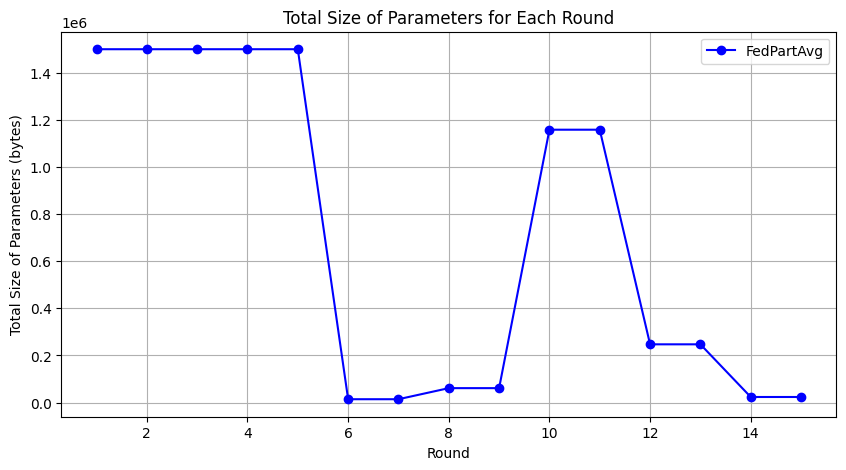

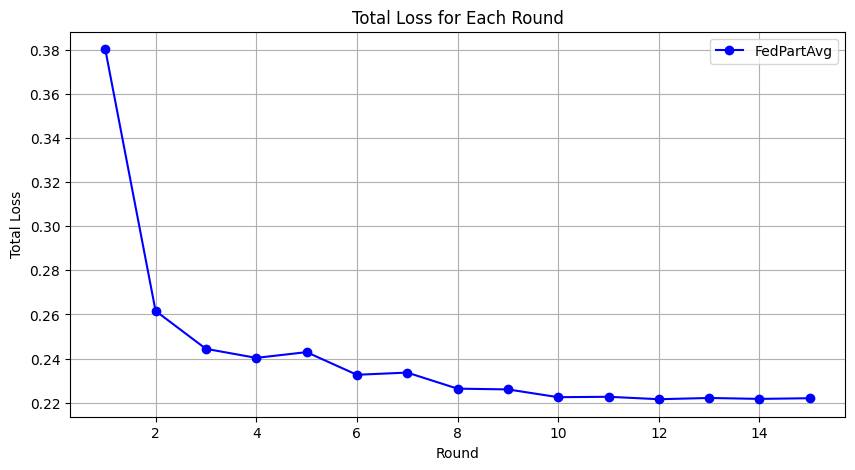

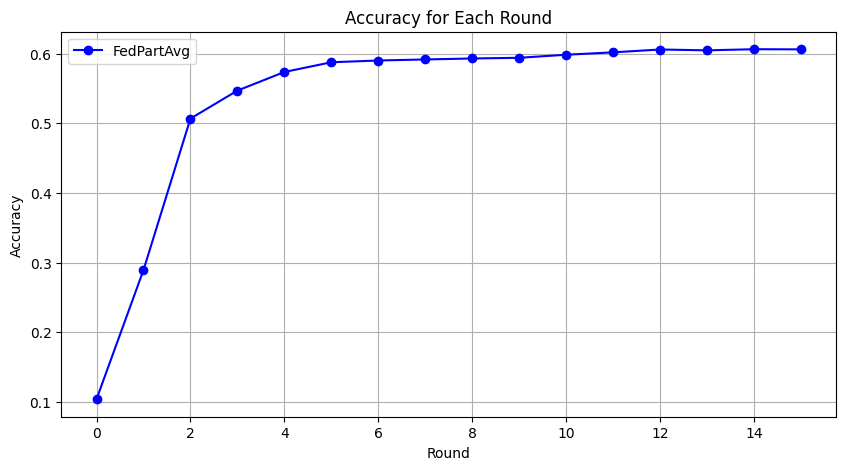

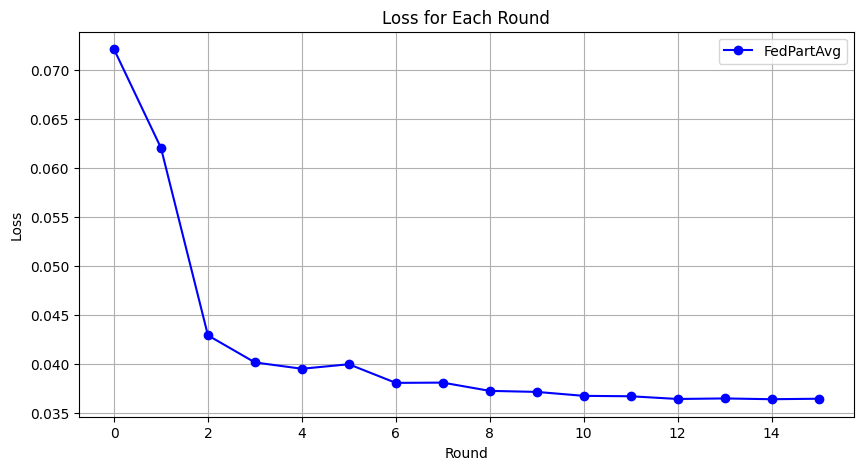

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the total size of parameters for each round
fed_part_avg_rounds = list(fed_part_avg_result.keys())
fed_part_avg_sizes = [fed_part_avg_result[round]["total_size"] for round in fed_part_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='b', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.legend()
plt.grid(True)

fed_part_avg_losses = [fed_part_avg_result[round]["total_loss"] for round in fed_part_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='b', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.legend()
plt.grid(True)


fed_part_avg_model_rounds = list(fed_part_avg_model_results.keys())
fed_part_avg_accuracies = [fed_part_avg_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='b', label='FedPartAvg')
# plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_part_avg_global_losses = [fed_part_avg_model_results[round]["global_loss"] for round in fed_part_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='b', label='FedPartAvg')
# plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='r', label='FedAvg')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss for Each Round')


# FedProx experiments:

In [15]:
class FedProxFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        global_params = copy.deepcopy(self.net).parameters()
        proxima_train(self.net, self.trainloader, EPOCHS, config["proximal_mu"], global_params)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedProxFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [16]:
fed_prox_result = {}

fed_prox_model_results = {}

class ModifiedFedProx(ModifiedFedAvg):

    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        proximal_mu: float,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.proximal_mu = proximal_mu


    def __repr__(self) -> str:
        return "ModifiedFedProx"
    

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> list[tuple[ClientProxy, FitIns]]:
        """Configure the next round of training.

        Sends the proximal factor mu to the clients
        """
        # Get the standard client/config pairs from the FedAvg super-class
        client_config_pairs = super().configure_fit(
            server_round, parameters, client_manager
        )

        # Return client/config pairs with the proximal factor mu added
        return [
            (
                client,
                FitIns(
                    fit_ins.parameters,
                    {**fit_ins.config, "proximal_mu": self.proximal_mu},
                ),
            )
            for client, fit_ins in client_config_pairs
        ]
    
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_prox_result.get(server_round):
            fed_prox_result[server_round]["total_size"] = total_size
        else:
            fed_prox_result[server_round] = {"total_size": total_size}
        

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_prox_result.get(server_round):
            fed_prox_result[server_round]["total_loss"] = total_loss
        else:
            fed_prox_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated
    

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_prox_model_results:  
            expand_fed_prox_model_results= {**fed_prox_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_prox_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_prox_model_results[server_round] = expand_fed_prox_model_results
        
        loss, metrics = eval_res
        return loss, metrics


In [17]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=ModifiedFedProx(proximal_mu=0.1, evaluate_fn=evaluate_fn),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=15, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.0721480214357376, {'accuracy': 0.1074}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=93812) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93812)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=93812) [Client 5] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=93812) Epoch 1: train loss 0.06380127370357513, accuracy 0.24857485748574856
(ClientAppActor pid=93816) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=93812) Epoch 3: train loss 0.05023343488574028, accuracy 0.41344134413441347 [repeated 12x across cluster]
(ClientAppActor pid=93812) Epoch 5: train loss 0.04425385594367981, accuracy 0.48694869486948694 [repeated 12x across cluster]
(ClientAppActor pid=93812) Epoch 7: train loss 0.04034034535288811, accuracy 0.5312031203120312 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (1, 0.05375157614946365, {'accuracy': 0.4245}, 32.00054712500423)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=93813) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=93813)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=93813) [Client 4] evaluate, config: {}
(ClientAppActor pid=93816) Epoch 8: train loss 0.038852911442518234, accuracy 0.5461226938653068 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=93814) [Client 2] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=93817) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=93814) Epoch 1: train loss 0.045886166393756866, accuracy 0.4642964296429643
(ClientAppActor pid=93815) Epoch 1: train loss 0.046315986663103104, accuracy 0.4624962496249625
(ClientAppActor pid=93812) [Client 1] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=93814) Epoch 3: train loss 0.039668358862400055, accuracy 0.5459045904590459 [repeated 11x across cluster]
(ClientAppActor pid=93814) Epoch 5: train loss 0.0345604345202446, accuracy 0.5975097509750975 [repeated 12x across cluster]
(ClientAppActor pid=93813) Epoch 7: train loss 0.030416889116168022, accuracy 0.653015301530153 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (2, 0.038976586776971814, {'accuracy': 0.5624}, 61.805472832988016)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=93815) [Client 3] evaluate, config: {}
(ClientAppActor pid=93812) Epoch 8: train loss 0.027390677481889725, accuracy 0.6871156442177891 [repeated 11x across cluster]


(ClientAppActor pid=93815) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93815)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=93814) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=93813) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=93814) Epoch 1: train loss 0.038354650139808655, accuracy 0.5641217939103045
(ClientAppActor pid=93815) Epoch 1: train loss 0.037718258798122406, accuracy 0.5679567956795679
(ClientAppActor pid=93813) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=93815) Epoch 3: train loss 0.030622301623225212, accuracy 0.6510651065106511 [repeated 11x across cluster]
(ClientAppActor pid=93813) Epoch 5: train loss 0.02516818419098854, accuracy 0.7158715871587159 [repeated 12x across cluster]
(ClientAppActor pid=93813) Epoch 7: train loss 0.019576838240027428, accuracy 0.780978097809781 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (3, 0.04090367051959038, {'accuracy': 0.5834}, 92.15131691598799)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=93813) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93813)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93813) [Client 5] evaluate, config: {}
(ClientAppActor pid=93817) Epoch 8: train loss 0.016598889604210854, accuracy 0.8162591870406479 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=93814) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=93812) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=93813) Epoch 1: train loss 0.03403608873486519, accuracy 0.6137113711371137
(ClientAppActor pid=93814) Epoch 1: train loss 0.033716943114995956, accuracy 0.6214189290535473
(ClientAppActor pid=93817) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=93812) Epoch 3: train loss 0.025454632937908173, accuracy 0.7174141292935353 [repeated 12x across cluster]
(ClientAppActor pid=93812) Epoch 5: train loss 0.01916106604039669, accuracy 0.7886605669716514 [repeated 12x across cluster]
(ClientAppActor pid=93813) Epoch 7: train loss 0.011981668882071972, accuracy 0.8681368136813682 [repeated 11x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (4, 0.048134636187553405, {'accuracy': 0.5801}, 122.47776624996914)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=93815) [Client 2] evaluate, config: {}
(ClientAppActor pid=93817) Epoch 8: train loss 0.011072514578700066, accuracy 0.8832883288328833 [repeated 11x across cluster]


(ClientAppActor pid=93812) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93812)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=93812) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=93814) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=93813) Epoch 1: train loss 0.03229626268148422, accuracy 0.6451177441127943
(ClientAppActor pid=93812) Epoch 1: train loss 0.0332324281334877, accuracy 0.6287128712871287
(ClientAppActor pid=93817) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=93813) Epoch 3: train loss 0.018653402104973793, accuracy 0.7885105744712765 [repeated 11x across cluster]
(ClientAppActor pid=93813) Epoch 5: train loss 0.012786691077053547, accuracy 0.8591570421478926 [repeated 12x across cluster]
(ClientAppActor pid=93813) Epoch 7: train loss 0.008213137276470661, accuracy 0.9151042447877606 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (5, 0.05361870565414429, {'accuracy': 0.5807}, 151.49613066599704)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=93817) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93817) [Client 0] evaluate, config: {}
(ClientAppActor pid=93817) Epoch 8: train loss 0.00666172057390213, accuracy 0.931893189318932 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=93815) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=93813) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=93813) Epoch 1: train loss 0.030923942103981972, accuracy 0.6712164391780411
(ClientAppActor pid=93815) Epoch 1: train loss 0.031156137585639954, accuracy 0.6650667466626669
(ClientAppActor pid=93817) [Client 5] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=93815) Epoch 3: train loss 0.015425428748130798, accuracy 0.8288585570721464 [repeated 12x across cluster]
(ClientAppActor pid=93816) Epoch 5: train loss 0.009909363463521004, accuracy 0.8966396639663966 [repeated 12x across cluster]
(ClientAppActor pid=93816) Epoch 7: train loss 0.006726853549480438, accuracy 0.9323432343234324 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (6, 0.06150716534852982, {'accuracy': 0.5782}, 180.20048150001094)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=93817) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93817) [Client 0] evaluate, config: {}
(ClientAppActor pid=93817) Epoch 8: train loss 0.0040498096495866776, accuracy 0.9624962496249625 [repeated 10x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=93814) [Client 4] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=93813) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=93816) Epoch 1: train loss 0.030135860666632652, accuracy 0.6808159592020399
(ClientAppActor pid=93814) Epoch 1: train loss 0.028738750144839287, accuracy 0.695019501950195
(ClientAppActor pid=93813) [Client 0] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=93814) Epoch 3: train loss 0.012243367731571198, accuracy 0.8670867086708671 [repeated 11x across cluster]
(ClientAppActor pid=93816) Epoch 5: train loss 0.006748051382601261, accuracy 0.9314534273286336 [repeated 12x across cluster]
(ClientAppActor pid=93816) Epoch 7: train loss 0.0046685184352099895, accuracy 0.9530523473826309 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=93817) Epoch 8: train loss 0.004263930954039097, accuracy 0.9548454845484549 [repeated 11x across cluster]
total size: 1499520


INFO :      fit progress: (7, 0.06689289273619652, {'accuracy': 0.5749}, 210.6932447499712)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=93813) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93813)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93813) [Client 2] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=93814) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=93814) Epoch 1: train loss 0.028867825865745544, accuracy 0.7082645867706615
(ClientAppActor pid=93812) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=93813) [Client 5] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=93816) Epoch 3: train loss 0.010011190548539162, accuracy 0.8898889888988899 [repeated 12x across cluster]
(ClientAppActor pid=93814) Epoch 5: train loss 0.005239277612417936, accuracy 0.9485525723713815 [repeated 12x across cluster]
(ClientAppActor pid=93814) Epoch 7: train loss 0.004386094864457846, accuracy 0.9572521373931303 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (8, 0.07107973533272743, {'accuracy': 0.5721}, 239.28893375000916)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=93817) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93814) [Client 4] evaluate, config: {}
(ClientAppActor pid=93817) Epoch 8: train loss 0.005499320570379496, accuracy 0.9426942694269427 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=93816) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=93812) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=93817) Epoch 1: train loss 0.027908461168408394, accuracy 0.7208220822082209
(ClientAppActor pid=93813) Epoch 1: train loss 0.02695365808904171, accuracy 0.7322633868306585
(ClientAppActor pid=93812) [Client 0] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=93812) Epoch 3: train loss 0.00869133323431015, accuracy 0.9083545822708865 [repeated 11x across cluster]
(ClientAppActor pid=93812) Epoch 5: train loss 0.004391709342598915, accuracy 0.959802009899505 [repeated 12x across cluster]
(ClientAppActor pid=93812) Epoch 7: train loss 0.00410022446885705, accuracy 0.9571021448927554 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (9, 0.0744504767358303, {'accuracy': 0.5686}, 266.8534189159982)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=93817) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93814) [Client 0] evaluate, config: {}
(ClientAppActor pid=93816) Epoch 8: train loss 0.005980849731713533, accuracy 0.9332433243324333 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=93817) [Client 5] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=93812) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=93815) Epoch 1: train loss 0.027016926556825638, accuracy 0.7314731473147315
(ClientAppActor pid=93814) Epoch 1: train loss 0.025537662208080292, accuracy 0.7398739873987399
(ClientAppActor pid=93812) [Client 0] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=93812) Epoch 3: train loss 0.00711737759411335, accuracy 0.9257537123143843 [repeated 11x across cluster]
(ClientAppActor pid=93815) Epoch 5: train loss 0.0037235848139971495, accuracy 0.9656465646564657 [repeated 12x across cluster]
(ClientAppActor pid=93814) Epoch 7: train loss 0.002477370435371995, accuracy 0.9753975397539754 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (10, 0.07746928275823593, {'accuracy': 0.566}, 296.2082459999947)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=93817) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93817) [Client 1] evaluate, config: {}
(ClientAppActor pid=93812) Epoch 8: train loss 0.004397453274577856, accuracy 0.9535023248837559 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=93816) [Client 2] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=93813) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=93816) Epoch 1: train loss 0.025722386315464973, accuracy 0.7377737773777377
(ClientAppActor pid=93814) Epoch 1: train loss 0.024954896420240402, accuracy 0.7495125243737814
(ClientAppActor pid=93813) [Client 0] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=93815) Epoch 3: train loss 0.005106357857584953, accuracy 0.9482448244824483 [repeated 11x across cluster]
(ClientAppActor pid=93812) Epoch 5: train loss 0.0032770598772913218, accuracy 0.9696969696969697 [repeated 12x across cluster]
(ClientAppActor pid=93812) Epoch 7: train loss 0.004290644079446793, accuracy 0.9563456345634563 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (11, 0.08010149075388909, {'accuracy': 0.5655}, 325.4992349999957)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=93817) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93814) [Client 0] evaluate, config: {}
(ClientAppActor pid=93814) Epoch 8: train loss 0.0044683367013931274, accuracy 0.9545522723863806 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=93817) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=93812) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=93817) Epoch 1: train loss 0.024227989837527275, accuracy 0.755925592559256
(ClientAppActor pid=93815) Epoch 1: train loss 0.024853825569152832, accuracy 0.7513124343782811
(ClientAppActor pid=93816) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=93813) Epoch 3: train loss 0.00465159397572279, accuracy 0.9524452445244525 [repeated 11x across cluster]
(ClientAppActor pid=93813) Epoch 5: train loss 0.0029111888725310564, accuracy 0.9713471347134713 [repeated 12x across cluster]
(ClientAppActor pid=93812) Epoch 7: train loss 0.00359899690374732, accuracy 0.9640017999100045 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (12, 0.08316612884402275, {'accuracy': 0.5662}, 353.5018552909605)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=93815) [Client 0] evaluate, config: {}
(ClientAppActor pid=93815) Epoch 8: train loss 0.00452066957950592, accuracy 0.9490025498725064 [repeated 11x across cluster]


(ClientAppActor pid=93812) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93812)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=93816) [Client 0] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=93816) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=93814) Epoch 1: train loss 0.023834895342588425, accuracy 0.7620762076207621
(ClientAppActor pid=93812) Epoch 1: train loss 0.02349487878382206, accuracy 0.7646264626462647


(ClientAppActor pid=93815) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=93815)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=93815) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=93812) Epoch 3: train loss 0.003760573687031865, accuracy 0.9660966096609661 [repeated 10x across cluster]
(ClientAppActor pid=93812) Epoch 5: train loss 0.0035843332298099995, accuracy 0.963996399639964 [repeated 12x across cluster]
(ClientAppActor pid=93812) Epoch 7: train loss 0.0034072124399244785, accuracy 0.9636963696369637 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520
(ClientAppActor pid=93815) Epoch 8: train loss 0.003872606670483947, accuracy 0.9566456645664566 [repeated 12x across cluster]


INFO :      fit progress: (13, 0.08339998935461045, {'accuracy': 0.5653}, 384.56196595798247)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=93814) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93814)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=93812) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=93812)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=93814) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=93814) [Client 5] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=93814) Epoch 1: train loss 0.02220313996076584, accuracy 0.7728772877287728
(ClientAppActor pid=93817) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=93817) [Client 0] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=93814) Epoch 3: train loss 0.003555369097739458, accuracy 0.9641464146414641 [repeated 12x across cluster]
(ClientAppActor pid=93814) Epoch 5: train loss 0.0016635592328384519, accuracy 0.9864986498649865 [repeated 12x across cluster]
(ClientAppActor pid=93814) Epoch 7: train loss 0.0068112886510789394, accuracy 0.9207920792079208 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (14, 0.08720038958787918, {'accuracy': 0.5682}, 412.5892559160129)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=93814) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=93814)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=93814) [Client 4] evaluate, config: {}
(ClientAppActor pid=93817) Epoch 8: train loss 0.0032884313259273767, accuracy 0.9664016799160042 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=93813) [Client 5] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=93817) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=93813) Epoch 1: train loss 0.02210822142660618, accuracy 0.7781278127812782
(ClientAppActor pid=93816) Epoch 1: train loss 0.020677931606769562, accuracy 0.7847284728472848
(ClientAppActor pid=93812) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=93813) Epoch 3: train loss 0.003157740691676736, accuracy 0.9716471647164716 [repeated 11x across cluster]
(ClientAppActor pid=93813) Epoch 5: train loss 0.0014900292735546827, accuracy 0.9888988898889889 [repeated 12x across cluster]
(ClientAppActor pid=93813) Epoch 7: train loss 0.005143067333847284, accuracy 0.9405940594059405 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (15, 0.08954223319292068, {'accuracy': 0.5651}, 440.5774486250011)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=93817) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=93817)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=93817) [Client 0] evaluate, config: {}
(ClientAppActor pid=93817) Epoch 8: train loss 8.789664570940658e-05, accuracy 1.0 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 15 round(s) in 443.37s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.054931632913701234
INFO :      		round 2: 0.04011997059613341
INFO :      		round 3: 0.042668996383248864
INFO :      		round 4: 0.0499896160392776
INFO :      		round 5: 0.055888741767820556
INFO :      		round 6: 0.06382143916735042
INFO :      		round 7: 0.06954907066734818
INFO :      		round 8: 0.07311274947679987
INFO :      		round 9: 0.07641113269674323
INFO :      		round 10: 0.07914080787845343
INFO :      		round 11: 0.08216487243002783
INFO :      		round 12: 0.08494564727693833
INFO :      		round 13: 0.08475411017987125
INFO :      		round 14: 0.08995520605905896
INFO :      		round 15: 0.09186184598872686
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.0721480214357376
INFO :      		round 1: 0.05375157614946365
INFO :      		round 2: 0.0389

(ClientAppActor pid=93816) [Client 4] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=93816) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=93816)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [18]:
fed_prox_rounds = list(fed_prox_result.keys())
fed_prox_sizes = [fed_prox_result[round]["total_size"] for round in fed_prox_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_prox_rounds, fed_prox_sizes, marker='o', linestyle='-', color='b', label='FedProx')
# plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Size of Parameters (bytes)')
# plt.title('Total Size of Parameters for Each Round')
# plt.legend()
# plt.grid(True)

fed_prox_losses = [fed_prox_result[round]["total_loss"] for round in fed_prox_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_prox_rounds, fed_prox_losses, marker='o', linestyle='-', color='b', label='FedProx')
# plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Loss')
# plt.title('Total Loss for Each Round')
# plt.legend()
# plt.grid(True)


fed_prox_model_rounds = list(fed_prox_model_results.keys())
fed_prox_accuracies = [fed_prox_model_results[round]["global_metrics"]["accuracy"] for round in fed_prox_model_rounds]

plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Accuracy')
# plt.title('Accuracy for Each Round')
# plt.legend()
# plt.grid(True)

fed_prox_global_losses = [fed_prox_model_results[round]["global_loss"] for round in fed_prox_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')   
# plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.title('Loss for Each Round')
# plt.legend()
# plt.grid(True)


<Figure size 1000x500 with 0 Axes>

# FedProxPart Experiments

In [19]:
class FedProxPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = [parameters[config["trainable_layers"]*2], parameters[config["trainable_layers"]*2 +1]]
        return trained_layer

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        global_params = copy.deepcopy(self.net).parameters()
        freeze_layers(self.net, config["trainable_layers"])
        proxima_train(self.net, self.trainloader, EPOCHS, config["proximal_mu"], global_params)
        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedProxPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [20]:
fed_part_prox_result = {}

fed_part_prox_model_results = {}

class FedPartProx(FedPartAvg):

    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        proximal_mu: float,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.proximal_mu = proximal_mu


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> list[tuple[ClientProxy, FitIns]]:
        """Configure the next round of training.

        Sends the proximal factor mu to the clients
        """
        # Get the standard client/config pairs from the FedAvg super-class
        client_config_pairs = super().configure_fit(
            server_round, parameters, client_manager
        )

        # Return client/config pairs with the proximal factor mu added
        return [
            (
                client,
                FitIns(
                    fit_ins.parameters,
                    {**fit_ins.config, "proximal_mu": self.proximal_mu},
                ),
            )
            for client, fit_ins in client_config_pairs
        ]
    
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        print(f"total size: {total_size}")
        
        if fed_part_prox_result.get(server_round):
            fed_part_prox_result[server_round]["total_size"] = total_size
        else:
            fed_part_prox_result[server_round] = {"total_size": total_size}
        


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        aggregated_weights = aggregate(weights_results)
        # parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))

        if self.layer_training_sequence[self.training_sequence_index -1] == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            print(f"updateing layers {self.layer_training_sequence[self.training_sequence_index -1]* 2}  and {self.layer_training_sequence[self.training_sequence_index -1]* 2 + 1} ")
            current_model[self.layer_training_sequence[self.training_sequence_index -1]* 2] = aggregated_weights[0]
            current_model[self.layer_training_sequence[self.training_sequence_index -1]* 2 +1] = aggregated_weights[1]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated
    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_part_prox_result.get(server_round):
            fed_part_prox_result[server_round]["total_loss"] = total_loss
        else:
            fed_part_prox_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated
    

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_part_prox_model_results:  
            expand_fed_part_prox_model_results= {**fed_part_prox_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_part_prox_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_part_prox_model_results[server_round] = expand_fed_part_prox_model_results
        
        loss, metrics = eval_res
        return loss, metrics


In [21]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedPartProx(proximal_mu=0.1, evaluate_fn=evaluate_fn),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=15, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.0721383546113968, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=7269) [Client 5] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=7269) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=7269) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=7269) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=7269) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=7269) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=7269) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=7269) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=7269) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=7269) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=7269) layer index is 9 and namefc3.bias is trainabe


(ClientAppActor pid=7271) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=7271)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=7269) Epoch 1: train loss 0.0627904087305069, accuracy 0.24557455745574558
(ClientAppActor pid=7272) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=7272) layer index is 9 and namefc3.bias is trainabe [repeated 50x across cluster]
(ClientAppActor pid=7271) Epoch 3: train loss 0.04994257166981697, accuracy 0.41794179417941796 [repeated 12x across cluster]
(ClientAppActor pid=7269) Epoch 5: train loss 0.044424355030059814, accuracy 0.47914791479147917 [repeated 12x across cluster]
(ClientAppActor pid=7269) Epoch 7: train loss 0.040215276181697845, accuracy 0.5261026102610261 [repeated 12x across cluster]
(ClientAppActor pid=7269) [Client 5] get_parameters


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (1, 0.0521854456782341, {'accuracy': 0.44}, 30.794293084007222)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=7273) [Client 3] evaluate, config: {}
(ClientAppActor pid=7272) Epoch 8: train loss 0.03882830590009689, accuracy 0.5543054305430543 [repeated 11x across cluster]


(ClientAppActor pid=7273) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=7273)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=7272) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=7272) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=7272) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=7272) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=7272) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=7272) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=7272) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=7272) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=7272) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=7272) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=7272) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=7272) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor p

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (2, 0.03837194428443909, {'accuracy': 0.57}, 58.403435459011234)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=7270) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=7270)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=7274) [Client 2] evaluate, config: {}
(ClientAppActor pid=7273) Epoch 8: train loss 0.027373865246772766, accuracy 0.6842184218421842 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=7272) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=7272) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=7272) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=7272) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=7272) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=7272) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=7272) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=7272) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=7272) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=7272) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=7272) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=7273) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor p

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (3, 0.040513250124454496, {'accuracy': 0.5881}, 89.19891391700367)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=7270) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=7270)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=7270) [Client 3] evaluate, config: {}
(ClientAppActor pid=7274) Epoch 8: train loss 0.01692299358546734, accuracy 0.8111311131113111 [repeated 11x across cluster]
(ClientAppActor pid=7274) [Client 5] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=7270) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=7270) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=7270) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=7270) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=7270) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=7270) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=7270) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=7270) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=7270) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=7270) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=7270) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=7269) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppA

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (4, 0.045734364438056944, {'accuracy': 0.5931}, 119.24695599998813)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=7271) [Client 0] evaluate, config: {}
(ClientAppActor pid=7271) Epoch 8: train loss 0.010875835083425045, accuracy 0.8823882388238824 [repeated 11x across cluster]
(ClientAppActor pid=7271) [Client 2] get_parameters [repeated 5x across cluster]


(ClientAppActor pid=7271) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=7271)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=7274) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': -1}
(ClientAppActor pid=7274) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=7274) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=7274) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=7274) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=7274) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=7274) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=7274) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=7274) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=7274) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=7274) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=7270) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppA

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1499520


INFO :      fit progress: (5, 0.05258321294784546, {'accuracy': 0.5946}, 147.27706183400005)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=7272) [Client 2] evaluate, config: {}
(ClientAppActor pid=7271) Epoch 8: train loss 0.006464514881372452, accuracy 0.9332433243324333 [repeated 11x across cluster]


(ClientAppActor pid=7274) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=7274)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=7269) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=7269) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=7269) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=7269) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=7269) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=7269) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=7269) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=7269) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=7269) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=7269) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=7269) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=7271) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=7273) [Client 

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 14016
updateing layers 0  and 1 


INFO :      fit progress: (6, 0.04531793167591095, {'accuracy': 0.5922}, 173.6444654170191)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=7270) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=7270)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=7270) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=7272) [Client 3] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0}
(ClientAppActor pid=7272) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=7272) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=7272) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=7272) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=7272) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=7272) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=7272) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=7272) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=7272) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=7272) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=7274) [Client 5] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=7274) Epoch 8:

(ClientAppActor pid=7274) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=7274)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=7274) [Client 2] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 0} [repeated 5x across cluster]
(ClientAppActor pid=7274) layer index is 1 and nameconv1.bias is trainabe [repeated 10x across cluster]
(ClientAppActor pid=7274) layer index is 9 and namefc3.bias is frozen [repeated 40x across cluster]
(ClientAppActor pid=7270) Epoch 2: train loss 0.026967233046889305, accuracy 0.7076207620762076 [repeated 8x across cluster]
(ClientAppActor pid=7274) Epoch 4: train loss 0.028173992410302162, accuracy 0.6927692769276927 [repeated 16x across cluster]
(ClientAppActor pid=7274) Epoch 6: train loss 0.028034832328557968, accuracy 0.6920192019201921 [repeated 14x across cluster]
(ClientAppActor pid=7271) [Client 1] get_parameters


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 14016
updateing layers 0  and 1 


INFO :      fit progress: (7, 0.0440764296233654, {'accuracy': 0.5931}, 201.73550400004024)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=7269) [Client 3] evaluate, config: {}
(ClientAppActor pid=7274) Epoch 8: train loss 0.027911486104130745, accuracy 0.6927692769276927 [repeated 10x across cluster]
(ClientAppActor pid=7274) [Client 2] get_parameters [repeated 5x across cluster]


(ClientAppActor pid=7271) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=7271)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=7269) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=7269)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=7272) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=7272) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=7272) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=7272) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=7272) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=7272) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=7272) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=7272) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=7272) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=7272) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=7272) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=7274) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7271) Ep

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 61056
updateing layers 2  and 3 


INFO :      fit progress: (8, 0.04250561745166779, {'accuracy': 0.5947}, 223.8418698339956)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=7271) [Client 5] evaluate, config: {}


(ClientAppActor pid=7271) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=7271)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=7270) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=7270) Epoch 8: train loss 0.024784643203020096, accuracy 0.7199219921992199 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=7274) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 1}
(ClientAppActor pid=7274) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=7274) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=7274) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=7274) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=7274) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=7274) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=7274) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=7274) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=7274) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=7274) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=7269) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7269) Ep

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 61056
updateing layers 2  and 3 


INFO :      fit progress: (9, 0.04213111068606377, {'accuracy': 0.5942}, 247.4641720840009)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=7272) [Client 1] evaluate, config: {}
(ClientAppActor pid=7270) Epoch 8: train loss 0.02365565486252308, accuracy 0.7300134993250338 [repeated 11x across cluster]


(ClientAppActor pid=7270) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=7270)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=7272) [Client 4] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=7272) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=7272) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=7272) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=7272) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=7272) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=7272) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=7272) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=7272) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=7272) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=7272) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=7270) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=7273) [Client 

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1157952
updateing layers 4  and 5 


INFO :      fit progress: (10, 0.0440522158741951, {'accuracy': 0.6052}, 268.54755512502743)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=7271) [Client 2] evaluate, config: {}


(ClientAppActor pid=7271) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=7271)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=7272) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=7272) Epoch 8: train loss 0.005876027047634125, accuracy 0.963096309630963 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=7274) [Client 3] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2}
(ClientAppActor pid=7274) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=7274) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=7274) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=7274) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=7274) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=7274) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=7274) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=7274) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=7274) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=7274) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=7272) [Client 0] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=7271) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=7271)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=7270) Epoch 2: train loss 0.016223860904574394, accuracy 0.819081908190819 [repeated 6x across cluster]
(ClientAppActor pid=7271) [Client 5] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 2} [repeated 5x across cluster]
(ClientAppActor pid=7271) layer index is 9 and namefc3.bias is frozen [repeated 40x across cluster]
(ClientAppActor pid=7271) layer index is 5 and namefc1.bias is trainabe [repeated 10x across cluster]
(ClientAppActor pid=7271) Epoch 3: train loss 0.013035271316766739, accuracy 0.8634863486348635 [repeated 17x across cluster]
(ClientAppActor pid=7271) Epoch 6: train loss 0.0070297205820679665, accuracy 0.9512451245124512 [repeated 18x across cluster]
(ClientAppActor pid=7273) [Client 1] get_parameters


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 1157952
updateing layers 4  and 5 


INFO :      fit progress: (11, 0.04524401196241379, {'accuracy': 0.6035}, 292.2551038340316)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=7271) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=7271)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=7270) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=7270)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=7270) [Client 2] evaluate, config: {}
(ClientAppActor pid=7271) Epoch 8: train loss 0.005154401063919067, accuracy 0.972997299729973 [repeated 7x across cluster]
(ClientAppActor pid=7271) [Client 5] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=7272) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=7272) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=7272) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=7272) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=7272) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=7272) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=7272) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=7272) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=7272) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=7272) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=7272) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=7269) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7272) Ep

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 247008
updateing layers 6  and 7 


INFO :      fit progress: (12, 0.041836442053318025, {'accuracy': 0.6025}, 310.62821945903124)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=7269) [Client 4] evaluate, config: {}
(ClientAppActor pid=7270) Epoch 8: train loss 0.016752077266573906, accuracy 0.8171317131713172 [repeated 17x across cluster]


(ClientAppActor pid=7269) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=7269)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=7270) [Client 4] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=7273) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 3}
(ClientAppActor pid=7273) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=7273) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=7273) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=7273) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=7273) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=7273) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=7273) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=7273) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=7273) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=7273) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=7274) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=7272) Ep

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=7272) [Client 2] get_parameters
total size: 247008
updateing layers 6  and 7 


INFO :      fit progress: (13, 0.04158252459168434, {'accuracy': 0.6056}, 328.4889700420317)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=7270) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=7270)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=7270) [Client 0] evaluate, config: {}
(ClientAppActor pid=7270) Epoch 8: train loss 0.017248177900910378, accuracy 0.806930693069307 [repeated 17x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=7274) [Client 1] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=7274) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=7274) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=7274) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=7274) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=7274) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=7274) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=7274) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=7274) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=7274) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=7274) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=7270) [Client 3] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=7272) [Client 

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 23472
updateing layers 8  and 9 


INFO :      fit progress: (14, 0.04121344859600067, {'accuracy': 0.6024}, 347.4814579170197)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=7272) [Client 3] evaluate, config: {}
(ClientAppActor pid=7270) Epoch 8: train loss 0.01906071975827217, accuracy 0.7821782178217822 [repeated 17x across cluster]


(ClientAppActor pid=7272) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=7272)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=7269) [Client 0] fit, config: {'proximal_mu': 0.1, 'trainable_layers': 4}
(ClientAppActor pid=7269) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=7269) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=7269) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=7269) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=7269) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=7269) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=7269) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=7269) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=7269) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=7269) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=7270) [Client 4] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=7269) [Client 

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 23472
updateing layers 8  and 9 


INFO :      fit progress: (15, 0.041207816660404205, {'accuracy': 0.6021}, 367.9594626670005)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=7270) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=7270)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=7270) [Client 1] evaluate, config: {}
(ClientAppActor pid=7270) [Client 1] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=7270) Epoch 8: train loss 0.02002553641796112, accuracy 0.7697615119244038 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 15 round(s) in 371.54s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.053263523725957024
INFO :      		round 2: 0.03914076291431405
INFO :      		round 3: 0.04134548092110112
INFO :      		round 4: 0.04659077690806634
INFO :      		round 5: 0.05359256501896004
INFO :      		round 6: 0.04636042165985062
INFO :      		round 7: 0.04512577488127529
INFO :      		round 8: 0.043491990700098924
INFO :      		round 9: 0.043042151093888203
INFO :      		round 10: 0.04493081877468062
INFO :      		round 11: 0.046416549921226465
INFO :      		round 12: 0.042768847513880597
INFO :      		round 13: 0.04247973127809436
INFO :      		round 14: 0.04210731822463232
INFO :      		round 15: 0.04207305601836919
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.0721383546113968
INFO :      		round 1: 0.0521854456782341
INFO :      		round 2: 0.03

(ClientAppActor pid=7272) [Client 0] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=7272) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=7272)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [22]:
fed_part_prox_rounds = list(fed_part_prox_result.keys())
fed_part_prox_sizes = [fed_part_prox_result[round]["total_size"] for round in fed_part_prox_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_rounds, fed_part_prox_sizes, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Size of Parameters (bytes)')
# plt.title('Total Size of Parameters for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_prox_losses = [fed_part_prox_result[round]["total_loss"] for round in fed_part_prox_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_rounds, fed_part_prox_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Loss')
# plt.title('Total Loss for Each Round')
# plt.legend()
# plt.grid(True)


fed_part_prox_model_rounds = list(fed_part_prox_model_results.keys())
fed_part_prox_accuracies = [fed_part_prox_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_prox_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Accuracy')
# plt.title('Accuracy for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_prox_global_losses = [fed_part_prox_model_results[round]["global_loss"] for round in fed_part_prox_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')   
# plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.title('Loss for Each Round')
# plt.legend()
# plt.grid(True)




# FedPartMoon Experiments:

In [23]:
from typing import Union
import sys

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size

fed_moon_result = {}
fed_moon_model_results = {}

# basically same as normal FedAvg, just added freezing and modified result dict names
class FedMoon(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters


    def __repr__(self) -> str:
        return "FedMoon"
    
    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        self.layer_training_sequence = self.generate_layer_training_sequence()
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    def generate_layer_training_sequence(self) -> List[int]:
        """Generate a sequence of layers to train."""
        layer_training_sequence = []
        for _ in range(NUM_OF_CYCLES):
            for _ in range(NUM_OF_FULL_UPDATES_BETWEEN_CYCLES):
                    layer_training_sequence.append(-1)
            for layer in range(NETWORK_LEN):
                    layer_training_sequence.append(layer)
                    layer_training_sequence.append(layer)

        return layer_training_sequence


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        print(f"XXX IN EVALUATE")
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        print(f"XXX IN EVALUATE calling eval_res with params {parameters_ndarrays}")
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_moon_model_results:
            expand_fed_moon_result= {**fed_moon_model_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_moon_result= {"global_loss": loss, "global_metrics": metrics}

        fed_moon_model_results[server_round] = expand_fed_moon_result

        return loss, metrics


    def configure_fit(
        # includes layer freezing
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {"trainable_layers": self.layer_training_sequence[self.training_sequence_index]}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        print(f"Training on layer {self.layer_training_sequence}")
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    
    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]


    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        
        if server_round in fed_moon_result:
            expand_fed_moon_result= {**fed_moon_result[server_round], "total_size": total_size}
        else:
            expand_fed_moon_result= {"total_size": total_size}

        fed_moon_result[server_round] = expand_fed_moon_result

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        
        aggregated_weights = aggregate(weights_results)
        
        if self.layer_training_sequence[self.training_sequence_index -1] == -1:
            self.latest_parameters = ndarrays_to_parameters(aggregated_weights)
        else:
            current_model = parameters_to_ndarrays(self.latest_parameters)
            print(f"updateing layers {self.layer_training_sequence[self.training_sequence_index -1]* 2}  and {self.layer_training_sequence[self.training_sequence_index -1]* 2 + 1} ")
            current_model[self.layer_training_sequence[self.training_sequence_index -1]* 2] = aggregated_weights[0]
            current_model[self.layer_training_sequence[self.training_sequence_index -1]* 2 +1] = aggregated_weights[1]
            self.latest_parameters = ndarrays_to_parameters(current_model)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_moon_result:
            expand_fed_moon_result= {**fed_moon_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_moon_result= {"total_loss": total_loss}

        fed_moon_result[server_round] = expand_fed_moon_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [24]:
import os

class FedMoonPartFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.model_dir = "models"

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        if config["trainable_layers"] == -1:
            return parameters
        
        trained_layer = [parameters[config["trainable_layers"]*2], parameters[config["trainable_layers"]*2 +1]]
        return trained_layer

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")

        # load previous model
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            prev_model = copy.deepcopy(self.net)
        else:
            # initialise and load params from model_dir
            prev_model = type(self.net)() 
            prev_model.load_state_dict(
                torch.load(
                    os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt")
                )
            )

        # update params for current model (loading global params)
        set_parameters(self.net, parameters)

        # create global model (same params that were just loaded)
        global_model = type(self.net)()
        global_model.load_state_dict(self.net.state_dict())
        global_model.to(DEVICE)
        

        print(f"trainable layers: {config}")
        freeze_layers(self.net, config["trainable_layers"])
        train_moon(self.net, self.trainloader, global_model, prev_model, EPOCHS, 5, 0.5)

        # save current model 
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            os.makedirs(os.path.join(self.model_dir, str(self.partition_id)))
        torch.save(
            self.net.state_dict(),
            os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt"),
        )

        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test_moon(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = MoonNet().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedMoonPartFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

def get_evaluate_fn_moon(
    testloader: DataLoader,
    net: torch.nn.Module,
) -> Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]:
    """Return an evaluation function for server-side evaluation."""

    def evaluate(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Use the entire test set for evaluation."""
        
        # Copy model parameters to avoid modifying the original
        net_copy = copy.deepcopy(net)
        
        # Update model with the latest parameters
        params_dict = zip(net_copy.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        net_copy.load_state_dict(state_dict, strict=True)
        
        net_copy.to(DEVICE)
        net_copy.eval()

        # Test the model
        loss, accuracy = test_moon(net_copy, testloader)
        
        # Return loss and metrics
        return loss, {"accuracy": accuracy}

    return evaluate


In [25]:
# Train FedMOON


_, _, testloader = load_datasets(0, NUM_PARTITIONS)
net = MoonNet().to(DEVICE)
evaluate_fn = get_evaluate_fn_moon(testloader, net)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedMoon(
            evaluate_fn=evaluate_fn
        )
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=15, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[ 0.06516211, -0.10576764, -0.09244124, -0.05841546,
           0.09111902],
         [-0.06492762, -0.05925469, -0.08524125, -0.105427  ,
           0.03173224],
         [ 0.06142351,  0.05186347, -0.09742049,  0.06331842,
          -0.04495846],
         [-0.05167627, -0.02847034,  0.01647196, -0.00063121,
          -0.03518066],
         [ 0.03834673, -0.06435373,  0.00508166, -0.02087059,
           0.05967215]],

        [[ 0.11546042, -0.04123904, -0.02847339, -0.05467942,
          -0.0468179 ],
         [ 0.11420761, -0.08110628, -0.11407521, -0.01736184,
          -0.01927285],
         [ 0.02134794,  0.04872907,  0.07200485, -0.07252874,
           0.07885931],
         [-0.09588015,  0.08665758, -0.02123633, -0.09700708,
           0.04728807],
         [ 0.03127529, -0.0528226 , -0.00589945,  0.02669238,
           0.00082756]],

        [[-0.03055046,  0.0889262 ,  0.05538969,  0.06936746,
           0

INFO :      initial parameters (loss, other metrics): 0.07218039314746856, {'accuracy': 0.0996}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=19521) [Client 4] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=19521) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=19521) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=19521) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=19521) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=19521) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=19521) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=19521) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=19521) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=19521) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=19521) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=19521) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=19521) Started tr

(ClientAppActor pid=19521) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=19521)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=19525) Epoch: 0 Loss: 2.995834 Loss1: 2.203717 Loss2: 0.792116
(ClientAppActor pid=19524) [Client 2] fit, config: {'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=19524) trainable layers: {'trainable_layers': -1} [repeated 5x across cluster]
(ClientAppActor pid=19524) layer index is 9 and namefc3.bias is trainabe [repeated 50x across cluster]
(ClientAppActor pid=19524) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=19525) Epoch: 2 Loss: 2.403638 Loss1: 1.597776 Loss2: 0.805863 [repeated 12x across cluster]
(ClientAppActor pid=19525) Epoch: 4 Loss: 2.219407 Loss1: 1.418024 Loss2: 0.801383 [repeated 12x across cluster]
(ClientAppActor pid=19525) Epoch: 6 Loss: 2.072334 Loss1: 1.274595 Loss2: 0.797739 [repeated 12x across cluster]
(ClientAppActor pid=19525) [Client 1] get_parameters


INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-0.01930629, -0.18905744, -0.16690198, -0.14286524,
          -0.00511038],
         [-0.20568798, -0.19334117, -0.19404829, -0.22406355,
          -0.11249529],
         [-0.01900787, -0.02946196, -0.14727665,  0.01395325,
          -0.14280216],
         [-0.0540872 , -0.01737404,  0.06242648,  0.04221253,
          -0.05181754],
         [ 0.0945218 ,  0.01225056,  0.09963839,  0.05042211,
           0.08973996]],

        [[ 0.10598111, -0.05147488, -0.03402737, -0.07268221,
          -0.0790499 ],
         [ 0.05068899, -0.1404586 , -0.15422538, -0.07092257,
          -0.09992956],
         [ 0.00748991,  0.0357065 ,  0.08797993, -0.06202174,
           0.03991964],
         [-0.07105453,  0.12753643,  0.05331664, -0.02806507,
           0.05384789],
         [ 0.07469756,  0.01228578,  0.07506181,  0.08295227,
           0.01340579]],

        [[ 0.02023495,  0.13401696,  0.09771911,  0.09963191,
           0

INFO :      fit progress: (1, 0.0473754249215126, {'accuracy': 0.4502}, 34.63583370798733)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19525) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=19525)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=19524) [Client 0] evaluate, config: {}
(ClientAppActor pid=19524) Epoch: 7 Loss: 1.996470 Loss1: 1.206904 Loss2: 0.789566 [repeated 11x across cluster]
(ClientAppActor pid=19524) [Client 2] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=19522) [Client 3] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=19522) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=19522) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=19522) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=19522) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=19522) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=19522) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=19522) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=19522) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=19522) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=19522) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=19522) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=19522) Started tr

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-4.78683598e-02, -2.39887640e-01, -2.20952958e-01,
          -1.84557572e-01, -2.40209084e-02],
         [-2.58721918e-01, -2.63171226e-01, -2.65852481e-01,
          -2.86968738e-01, -1.57550871e-01],
         [-6.41254336e-02, -8.84460583e-02, -2.04671130e-01,
          -3.04308068e-02, -1.80047572e-01],
         [-5.27357608e-02, -1.94744766e-02,  7.09677413e-02,
           6.08085804e-02, -4.88844253e-02],
         [ 1.34086743e-01,  6.32432178e-02,  1.62870780e-01,
           1.05008811e-01,  1.29784688e-01]],

        [[ 1.14093982e-01, -6.23046122e-02, -5.09316698e-02,
          -8.18132237e-02, -7.31561556e-02],
         [ 3.52464132e-02, -1.67512670e-01, -1.85551777e-01,
          -9.66156498e-02, -1.15840420e-01],
         [-1.16962520e-02,  1.27160726e-02,  6.86484426e-02,
          -7.27282614e-02,  2.71858834e-02],
         [-7.84931332e-02,  1.28708109e-01,  6.77603483e-02,
          -6.30786549e-03, 

INFO :      fit progress: (2, 0.04266391940116882, {'accuracy': 0.5305}, 66.14342212496558)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19525) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19525)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19526) [Client 3] evaluate, config: {}
(ClientAppActor pid=19521) Epoch: 7 Loss: 3.998048 Loss1: 0.909887 Loss2: 3.088162 [repeated 11x across cluster]
(ClientAppActor pid=19521) [Client 0] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=19522) [Client 2] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=19522) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=19522) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=19522) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=19522) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=19522) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=19522) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=19522) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=19522) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=19522) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=19522) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=19522) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=19522) Started tr

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-7.10710138e-02, -2.74046570e-01, -2.57240206e-01,
          -2.09659249e-01, -2.54133809e-02],
         [-3.01487058e-01, -3.14045429e-01, -3.18771154e-01,
          -3.33758563e-01, -1.83926210e-01],
         [-9.49660465e-02, -1.28353700e-01, -2.45383814e-01,
          -6.15498126e-02, -1.99011147e-01],
         [-4.42428552e-02, -1.22651523e-02,  8.44729021e-02,
           7.51358494e-02, -4.26757075e-02],
         [ 1.69851646e-01,  1.01708606e-01,  2.08380684e-01,
           1.44018933e-01,  1.62600219e-01]],

        [[ 1.15224995e-01, -6.98658824e-02, -6.39128610e-02,
          -8.89527798e-02, -6.45957962e-02],
         [ 1.69301666e-02, -1.88015267e-01, -2.10914940e-01,
          -1.19556606e-01, -1.27136394e-01],
         [-2.71758083e-02, -3.23562766e-03,  5.22426851e-02,
          -8.33716020e-02,  2.01321766e-02],
         [-8.22335854e-02,  1.33973628e-01,  8.06538984e-02,
           3.99613893e-03, 

INFO :      fit progress: (3, 0.04268854308128357, {'accuracy': 0.5676}, 97.72117974999128)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19523) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19523)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19523) [Client 1] evaluate, config: {}
(ClientAppActor pid=19526) Epoch: 7 Loss: 2.097837 Loss1: 0.573084 Loss2: 1.524753 [repeated 11x across cluster]
(ClientAppActor pid=19526) [Client 4] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=19526) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=19526) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=19526) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=19526) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=19526) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=19526) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=19526) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=19526) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=19526) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=19526) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=19526) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=19526) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=19526) Started tr

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=19524) [Client 3] get_parameters
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-7.74841830e-02, -3.00999463e-01, -2.90792465e-01,
          -2.37400770e-01, -3.81500311e-02],
         [-3.28924149e-01, -3.60544890e-01, -3.71475875e-01,
          -3.81806791e-01, -2.14814529e-01],
         [-1.12022519e-01, -1.61498025e-01, -2.81689376e-01,
          -8.67263973e-02, -2.16742903e-01],
         [-2.91902162e-02, -2.65351008e-03,  9.64017212e-02,
           9.10817459e-02, -3.87455896e-02],
         [ 2.11055458e-01,  1.38811693e-01,  2.45719776e-01,
           1.77978083e-01,  1.84743121e-01]],

        [[ 1.27444923e-01, -7.39138350e-02, -7.49778897e-02,
          -9.63797718e-02, -6.30548745e-02],
         [ 8.21725000e-03, -2.07162172e-01, -2.35574633e-01,
          -1.40727893e-01, -1.39845908e-01],
         [-3.34117599e-02, -1.52210267e-02,  4.08438295e-02,
          -8.46517086e-02,  1.58136748e-02],
         [-7.93080181e-02,  1.41191

INFO :      fit progress: (4, 0.04642959678173065, {'accuracy': 0.5799}, 131.02250291698147)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19522) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19522)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19526) [Client 5] evaluate, config: {}
(ClientAppActor pid=19523) Epoch: 7 Loss: 1.943515 Loss1: 0.414666 Loss2: 1.528849 [repeated 11x across cluster]
(ClientAppActor pid=19523) [Client 2] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]


(ClientAppActor pid=19523) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=19523)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=19523) [Client 0] fit, config: {'trainable_layers': -1}
(ClientAppActor pid=19523) trainable layers: {'trainable_layers': -1}
(ClientAppActor pid=19523) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=19523) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=19523) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=19523) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=19523) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=19523) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=19523) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=19523) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=19523) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=19523) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=19523) Started training moon
(ClientAppActor pid=19524) [Client 4] evaluate, config: {

INFO :      aggregate_fit: received 6 results and 0 failures


XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-8.97237211e-02, -3.29086334e-01, -3.18683147e-01,
          -2.59139508e-01, -4.89060879e-02],
         [-3.59050781e-01, -4.04121220e-01, -4.14425939e-01,
          -4.19703424e-01, -2.38015577e-01],
         [-1.28801763e-01, -1.89902380e-01, -3.08168143e-01,
          -1.05915330e-01, -2.30240822e-01],
         [-1.89891439e-02,  3.19031999e-03,  1.12123422e-01,
           1.09267689e-01, -3.30222435e-02],
         [ 2.39462331e-01,  1.61938518e-01,  2.77957350e-01,
           2.08232820e-01,  2.05528781e-01]],

        [[ 1.29753590e-01, -8.24851543e-02, -8.30911249e-02,
          -9.92025137e-02, -5.96474707e-02],
         [-7.29497941e-03, -2.28099883e-01, -2.55272299e-01,
          -1.57079980e-01, -1.50052786e-01],
         [-4.16442528e-02, -2.71282531e-02,  3.31243016e-02,
          -8.74592066e-02,  9.97519586e-03],
         [-7.82556832e-02,  1.44863412e-01,  1.10620052e-01,
           3.99318561e-02, 

INFO :      fit progress: (5, 0.05116403185427189, {'accuracy': 0.5792}, 165.70286999997916)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19523) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=19523)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=19523) [Client 4] evaluate, config: {}
(ClientAppActor pid=19521) Epoch: 7 Loss: 1.676469 Loss1: 0.273188 Loss2: 1.403281 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=19523) [Client 5] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=19523) trainable layers: {'trainable_layers': 0}
(ClientAppActor pid=19523) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=19523) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=19523) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=19523) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=19523) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=19523) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=19523) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=19523) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=19523) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=19523) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=19523) Started training moon
(Clien

INFO :      aggregate_fit: received 6 results and 0 failures


updateing layers 0  and 1 
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-3.99234928e-02, -2.82917529e-01, -2.63268858e-01,
          -2.01846257e-01,  1.94663126e-02],
         [-2.89109468e-01, -3.34297240e-01, -3.43284249e-01,
          -3.59376311e-01, -1.77571803e-01],
         [-8.03698972e-02, -1.47999823e-01, -2.65954643e-01,
          -7.34063610e-02, -2.01847970e-01],
         [ 4.72090626e-03, -3.28259519e-03,  1.00500375e-01,
           1.00528345e-01, -3.69441062e-02],
         [ 2.47102529e-01,  1.46802261e-01,  2.57221103e-01,
           1.97159156e-01,  1.98077932e-01]],

        [[ 1.32006943e-01, -8.15019161e-02, -7.24203661e-02,
          -8.34511667e-02, -3.19810249e-02],
         [ 1.56812668e-02, -1.98803946e-01, -2.23702803e-01,
          -1.34361386e-01, -1.30856276e-01],
         [-3.09654344e-02, -1.72716863e-02,  4.35350053e-02,
          -8.71275514e-02,  4.15627146e-03],
         [-9.13584754e-02,  1.11518681e-01,  7.46396035e-02,


INFO :      fit progress: (6, 0.04415848556756973, {'accuracy': 0.5794}, 194.39850070799002)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19523) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19523)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19523) [Client 3] evaluate, config: {}
(ClientAppActor pid=19521) Epoch: 7 Loss: 3.179655 Loss1: 0.933425 Loss2: 2.246230 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=19524) [Client 5] fit, config: {'trainable_layers': 0}
(ClientAppActor pid=19524) trainable layers: {'trainable_layers': 0}
(ClientAppActor pid=19524) layer index is 0 and nameconv1.weight is trainabe
(ClientAppActor pid=19524) layer index is 1 and nameconv1.bias is trainabe
(ClientAppActor pid=19524) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=19524) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=19524) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=19524) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=19524) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=19524) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=19524) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=19524) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=19524) Started training moon
(Clien

INFO :      aggregate_fit: received 6 results and 0 failures


updateing layers 0  and 1 
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-2.73426790e-02, -2.66089529e-01, -2.34280691e-01,
          -1.76223636e-01,  4.47193794e-02],
         [-2.71181226e-01, -3.08731586e-01, -3.12153757e-01,
          -3.40347260e-01, -1.61583781e-01],
         [-7.13354871e-02, -1.30353421e-01, -2.51599520e-01,
          -6.67525753e-02, -1.98456690e-01],
         [ 1.28784571e-02, -1.01286033e-03,  9.07318518e-02,
           8.83909389e-02, -4.81843464e-02],
         [ 2.60712504e-01,  1.51808396e-01,  2.48927504e-01,
           1.94454342e-01,  1.97541684e-01]],

        [[ 1.22594245e-01, -8.31573978e-02, -6.27864376e-02,
          -7.53938332e-02, -2.49295570e-02],
         [ 1.50678931e-02, -1.85528547e-01, -2.04566970e-01,
          -1.26750052e-01, -1.31531149e-01],
         [-3.31640765e-02, -4.56212927e-03,  5.21683209e-02,
          -8.78612399e-02, -4.39880462e-03],
         [-9.96320471e-02,  1.07268475e-01,  6.12865016e-02,


INFO :      fit progress: (7, 0.04248106220960617, {'accuracy': 0.5808}, 225.24621650000336)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19523) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19523)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19523) [Client 1] evaluate, config: {}
(ClientAppActor pid=19522) Epoch: 7 Loss: 4.304935 Loss1: 0.885503 Loss2: 3.419432 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=19524) [Client 1] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=19524) trainable layers: {'trainable_layers': 1}
(ClientAppActor pid=19524) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=19524) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=19524) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=19524) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=19524) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=19524) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=19524) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=19524) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=19524) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=19524) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=19524) Started training moon
(Clien

INFO :      aggregate_fit: received 6 results and 0 failures


updateing layers 2  and 3 
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-2.73426790e-02, -2.66089529e-01, -2.34280691e-01,
          -1.76223636e-01,  4.47193794e-02],
         [-2.71181226e-01, -3.08731586e-01, -3.12153757e-01,
          -3.40347260e-01, -1.61583781e-01],
         [-7.13354871e-02, -1.30353421e-01, -2.51599520e-01,
          -6.67525753e-02, -1.98456690e-01],
         [ 1.28784571e-02, -1.01286033e-03,  9.07318518e-02,
           8.83909389e-02, -4.81843464e-02],
         [ 2.60712504e-01,  1.51808396e-01,  2.48927504e-01,
           1.94454342e-01,  1.97541684e-01]],

        [[ 1.22594245e-01, -8.31573978e-02, -6.27864376e-02,
          -7.53938332e-02, -2.49295570e-02],
         [ 1.50678931e-02, -1.85528547e-01, -2.04566970e-01,
          -1.26750052e-01, -1.31531149e-01],
         [-3.31640765e-02, -4.56212927e-03,  5.21683209e-02,
          -8.78612399e-02, -4.39880462e-03],
         [-9.96320471e-02,  1.07268475e-01,  6.12865016e-02,


INFO :      fit progress: (8, 0.04085826240181923, {'accuracy': 0.589}, 249.43168329197215)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19523) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19523)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19523) [Client 0] evaluate, config: {}
(ClientAppActor pid=19523) Epoch: 7 Loss: 4.168148 Loss1: 0.851771 Loss2: 3.316377 [repeated 11x across cluster]
(ClientAppActor pid=19523) [Client 5] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=19523) [Client 2] fit, config: {'trainable_layers': 1}
(ClientAppActor pid=19523) trainable layers: {'trainable_layers': 1}
(ClientAppActor pid=19523) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=19523) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=19523) layer index is 2 and nameconv2.weight is trainabe
(ClientAppActor pid=19523) layer index is 3 and nameconv2.bias is trainabe
(ClientAppActor pid=19523) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=19523) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=19523) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=19523) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=19523) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=19523) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=19523) Started training moon
(Clien

INFO :      aggregate_fit: received 6 results and 0 failures


updateing layers 2  and 3 
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-2.73426790e-02, -2.66089529e-01, -2.34280691e-01,
          -1.76223636e-01,  4.47193794e-02],
         [-2.71181226e-01, -3.08731586e-01, -3.12153757e-01,
          -3.40347260e-01, -1.61583781e-01],
         [-7.13354871e-02, -1.30353421e-01, -2.51599520e-01,
          -6.67525753e-02, -1.98456690e-01],
         [ 1.28784571e-02, -1.01286033e-03,  9.07318518e-02,
           8.83909389e-02, -4.81843464e-02],
         [ 2.60712504e-01,  1.51808396e-01,  2.48927504e-01,
           1.94454342e-01,  1.97541684e-01]],

        [[ 1.22594245e-01, -8.31573978e-02, -6.27864376e-02,
          -7.53938332e-02, -2.49295570e-02],
         [ 1.50678931e-02, -1.85528547e-01, -2.04566970e-01,
          -1.26750052e-01, -1.31531149e-01],
         [-3.31640765e-02, -4.56212927e-03,  5.21683209e-02,
          -8.78612399e-02, -4.39880462e-03],
         [-9.96320471e-02,  1.07268475e-01,  6.12865016e-02,


INFO :      fit progress: (9, 0.04019994685053825, {'accuracy': 0.5883}, 274.82362058298895)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19522) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19522)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19524) [Client 5] evaluate, config: {}
(ClientAppActor pid=19526) Epoch: 7 Loss: 4.120417 Loss1: 0.886179 Loss2: 3.234238 [repeated 11x across cluster]
(ClientAppActor pid=19526) [Client 5] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=19523) [Client 2] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=19523) trainable layers: {'trainable_layers': 2}
(ClientAppActor pid=19523) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=19523) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=19523) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=19523) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=19523) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=19523) layer index is 5 and namefc1.bias is trainabe
(ClientAppActor pid=19523) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=19523) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=19523) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=19523) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=19523) Started training moon
(Clien

INFO :      aggregate_fit: received 6 results and 0 failures


updateing layers 4  and 5 
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-2.73426790e-02, -2.66089529e-01, -2.34280691e-01,
          -1.76223636e-01,  4.47193794e-02],
         [-2.71181226e-01, -3.08731586e-01, -3.12153757e-01,
          -3.40347260e-01, -1.61583781e-01],
         [-7.13354871e-02, -1.30353421e-01, -2.51599520e-01,
          -6.67525753e-02, -1.98456690e-01],
         [ 1.28784571e-02, -1.01286033e-03,  9.07318518e-02,
           8.83909389e-02, -4.81843464e-02],
         [ 2.60712504e-01,  1.51808396e-01,  2.48927504e-01,
           1.94454342e-01,  1.97541684e-01]],

        [[ 1.22594245e-01, -8.31573978e-02, -6.27864376e-02,
          -7.53938332e-02, -2.49295570e-02],
         [ 1.50678931e-02, -1.85528547e-01, -2.04566970e-01,
          -1.26750052e-01, -1.31531149e-01],
         [-3.31640765e-02, -4.56212927e-03,  5.21683209e-02,
          -8.78612399e-02, -4.39880462e-03],
         [-9.96320471e-02,  1.07268475e-01,  6.12865016e-02,


INFO :      fit progress: (10, 0.0415569705426693, {'accuracy': 0.5962}, 296.9250834999839)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19523) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19523)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19523) [Client 1] evaluate, config: {}
(ClientAppActor pid=19526) Epoch: 7 Loss: 3.551674 Loss1: 0.382601 Loss2: 3.169073 [repeated 10x across cluster]
(ClientAppActor pid=19526) [Client 0] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=19524) [Client 1] fit, config: {'trainable_layers': 2}
(ClientAppActor pid=19524) trainable layers: {'trainable_layers': 2}
(ClientAppActor pid=19524) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=19524) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=19524) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=19524) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=19524) layer index is 4 and namefc1.weight is trainabe
(ClientAppActor pid=19526) Started training moon
(ClientAppActor pid=19524) 
(ClientAppActor pid=19526) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=19525) Epoch: 0 Loss: 3.334830 Loss1: 0.943872 Loss2: 2.390958 [repeated 3x across cluster]
(ClientAppActor pid=19523) [Client 5] fit, config: {'trainable_layers': 2} [repeated 5x across cluster]
(ClientAppActor pid=19523) trainabl

INFO :      aggregate_fit: received 6 results and 0 failures


updateing layers 4  and 5 
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-2.73426790e-02, -2.66089529e-01, -2.34280691e-01,
          -1.76223636e-01,  4.47193794e-02],
         [-2.71181226e-01, -3.08731586e-01, -3.12153757e-01,
          -3.40347260e-01, -1.61583781e-01],
         [-7.13354871e-02, -1.30353421e-01, -2.51599520e-01,
          -6.67525753e-02, -1.98456690e-01],
         [ 1.28784571e-02, -1.01286033e-03,  9.07318518e-02,
           8.83909389e-02, -4.81843464e-02],
         [ 2.60712504e-01,  1.51808396e-01,  2.48927504e-01,
           1.94454342e-01,  1.97541684e-01]],

        [[ 1.22594245e-01, -8.31573978e-02, -6.27864376e-02,
          -7.53938332e-02, -2.49295570e-02],
         [ 1.50678931e-02, -1.85528547e-01, -2.04566970e-01,
          -1.26750052e-01, -1.31531149e-01],
         [-3.31640765e-02, -4.56212927e-03,  5.21683209e-02,
          -8.78612399e-02, -4.39880462e-03],
         [-9.96320471e-02,  1.07268475e-01,  6.12865016e-02,


INFO :      fit progress: (11, 0.041906112283468244, {'accuracy': 0.593}, 319.1528784579714)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19522) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19522)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19526) [Client 3] evaluate, config: {}
(ClientAppActor pid=19523) Epoch: 7 Loss: 2.798392 Loss1: 0.410502 Loss2: 2.387889 [repeated 11x across cluster]
(ClientAppActor pid=19523) [Client 5] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=19523) [Client 3] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=19523) trainable layers: {'trainable_layers': 3}
(ClientAppActor pid=19523) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=19523) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=19523) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=19523) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=19523) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=19523) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=19523) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=19523) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=19523) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=19523) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=19523) Started training moon
(Clien

INFO :      aggregate_fit: received 6 results and 0 failures


updateing layers 6  and 7 
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-2.73426790e-02, -2.66089529e-01, -2.34280691e-01,
          -1.76223636e-01,  4.47193794e-02],
         [-2.71181226e-01, -3.08731586e-01, -3.12153757e-01,
          -3.40347260e-01, -1.61583781e-01],
         [-7.13354871e-02, -1.30353421e-01, -2.51599520e-01,
          -6.67525753e-02, -1.98456690e-01],
         [ 1.28784571e-02, -1.01286033e-03,  9.07318518e-02,
           8.83909389e-02, -4.81843464e-02],
         [ 2.60712504e-01,  1.51808396e-01,  2.48927504e-01,
           1.94454342e-01,  1.97541684e-01]],

        [[ 1.22594245e-01, -8.31573978e-02, -6.27864376e-02,
          -7.53938332e-02, -2.49295570e-02],
         [ 1.50678931e-02, -1.85528547e-01, -2.04566970e-01,
          -1.26750052e-01, -1.31531149e-01],
         [-3.31640765e-02, -4.56212927e-03,  5.21683209e-02,
          -8.78612399e-02, -4.39880462e-03],
         [-9.96320471e-02,  1.07268475e-01,  6.12865016e-02,


INFO :      fit progress: (12, 0.040305957823991774, {'accuracy': 0.589}, 342.18721474998165)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=19524) [Client 3] evaluate, config: {}
(ClientAppActor pid=19521) [Client 2] get_parameters [repeated 5x across cluster]
(ClientAppActor pid=19521) Epoch: 7 Loss: 2.528720 Loss1: 0.640617 Loss2: 1.888103 [repeated 5x across cluster]


(ClientAppActor pid=19524) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19524)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=19524) [Client 5] fit, config: {'trainable_layers': 3}
(ClientAppActor pid=19524) trainable layers: {'trainable_layers': 3}
(ClientAppActor pid=19524) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=19524) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=19524) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=19524) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=19524) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=19524) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=19524) layer index is 6 and namefc2.weight is trainabe
(ClientAppActor pid=19524) layer index is 7 and namefc2.bias is trainabe
(ClientAppActor pid=19524) layer index is 8 and namefc3.weight is frozen
(ClientAppActor pid=19524) layer index is 9 and namefc3.bias is frozen
(ClientAppActor pid=19524) Started training moon
(Clien

INFO :      aggregate_fit: received 6 results and 0 failures


updateing layers 6  and 7 
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-2.73426790e-02, -2.66089529e-01, -2.34280691e-01,
          -1.76223636e-01,  4.47193794e-02],
         [-2.71181226e-01, -3.08731586e-01, -3.12153757e-01,
          -3.40347260e-01, -1.61583781e-01],
         [-7.13354871e-02, -1.30353421e-01, -2.51599520e-01,
          -6.67525753e-02, -1.98456690e-01],
         [ 1.28784571e-02, -1.01286033e-03,  9.07318518e-02,
           8.83909389e-02, -4.81843464e-02],
         [ 2.60712504e-01,  1.51808396e-01,  2.48927504e-01,
           1.94454342e-01,  1.97541684e-01]],

        [[ 1.22594245e-01, -8.31573978e-02, -6.27864376e-02,
          -7.53938332e-02, -2.49295570e-02],
         [ 1.50678931e-02, -1.85528547e-01, -2.04566970e-01,
          -1.26750052e-01, -1.31531149e-01],
         [-3.31640765e-02, -4.56212927e-03,  5.21683209e-02,
          -8.78612399e-02, -4.39880462e-03],
         [-9.96320471e-02,  1.07268475e-01,  6.12865016e-02,


INFO :      fit progress: (13, 0.0397659372150898, {'accuracy': 0.5831}, 365.21598391700536)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19523) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=19523)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]


(ClientAppActor pid=19523) [Client 1] evaluate, config: {}
(ClientAppActor pid=19522) Epoch: 7 Loss: 2.321755 Loss1: 0.657496 Loss2: 1.664259 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=19524) [Client 2] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=19524) trainable layers: {'trainable_layers': 4}
(ClientAppActor pid=19524) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=19524) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=19524) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=19524) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=19524) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=19524) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=19524) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=19524) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=19524) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=19524) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=19524) Started training moon
(Clien

INFO :      aggregate_fit: received 6 results and 0 failures


updateing layers 8  and 9 
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-2.73426790e-02, -2.66089529e-01, -2.34280691e-01,
          -1.76223636e-01,  4.47193794e-02],
         [-2.71181226e-01, -3.08731586e-01, -3.12153757e-01,
          -3.40347260e-01, -1.61583781e-01],
         [-7.13354871e-02, -1.30353421e-01, -2.51599520e-01,
          -6.67525753e-02, -1.98456690e-01],
         [ 1.28784571e-02, -1.01286033e-03,  9.07318518e-02,
           8.83909389e-02, -4.81843464e-02],
         [ 2.60712504e-01,  1.51808396e-01,  2.48927504e-01,
           1.94454342e-01,  1.97541684e-01]],

        [[ 1.22594245e-01, -8.31573978e-02, -6.27864376e-02,
          -7.53938332e-02, -2.49295570e-02],
         [ 1.50678931e-02, -1.85528547e-01, -2.04566970e-01,
          -1.26750052e-01, -1.31531149e-01],
         [-3.31640765e-02, -4.56212927e-03,  5.21683209e-02,
          -8.78612399e-02, -4.39880462e-03],
         [-9.96320471e-02,  1.07268475e-01,  6.12865016e-02,


INFO :      fit progress: (14, 0.040984952014684675, {'accuracy': 0.5897}, 388.1374225829495)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19523) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19523)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19523) [Client 3] evaluate, config: {}
(ClientAppActor pid=19522) Epoch: 7 Loss: 3.048031 Loss1: 0.701653 Loss2: 2.346378 [repeated 11x across cluster]
(ClientAppActor pid=19522) [Client 5] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


Training on layer [-1, -1, -1, -1, -1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
(ClientAppActor pid=19524) [Client 5] fit, config: {'trainable_layers': 4}
(ClientAppActor pid=19524) trainable layers: {'trainable_layers': 4}
(ClientAppActor pid=19524) layer index is 0 and nameconv1.weight is frozen
(ClientAppActor pid=19524) layer index is 1 and nameconv1.bias is frozen
(ClientAppActor pid=19524) layer index is 2 and nameconv2.weight is frozen
(ClientAppActor pid=19524) layer index is 3 and nameconv2.bias is frozen
(ClientAppActor pid=19524) layer index is 4 and namefc1.weight is frozen
(ClientAppActor pid=19524) layer index is 5 and namefc1.bias is frozen
(ClientAppActor pid=19524) layer index is 6 and namefc2.weight is frozen
(ClientAppActor pid=19524) layer index is 7 and namefc2.bias is frozen
(ClientAppActor pid=19524) layer index is 8 and namefc3.weight is trainabe
(ClientAppActor pid=19524) layer index is 9 and namefc3.bias is trainabe
(ClientAppActor pid=19525) Started training moon
(Clien

INFO :      aggregate_fit: received 6 results and 0 failures


updateing layers 8  and 9 
XXX IN EVALUATE
XXX IN EVALUATE calling eval_res with params [array([[[[-2.73426790e-02, -2.66089529e-01, -2.34280691e-01,
          -1.76223636e-01,  4.47193794e-02],
         [-2.71181226e-01, -3.08731586e-01, -3.12153757e-01,
          -3.40347260e-01, -1.61583781e-01],
         [-7.13354871e-02, -1.30353421e-01, -2.51599520e-01,
          -6.67525753e-02, -1.98456690e-01],
         [ 1.28784571e-02, -1.01286033e-03,  9.07318518e-02,
           8.83909389e-02, -4.81843464e-02],
         [ 2.60712504e-01,  1.51808396e-01,  2.48927504e-01,
           1.94454342e-01,  1.97541684e-01]],

        [[ 1.22594245e-01, -8.31573978e-02, -6.27864376e-02,
          -7.53938332e-02, -2.49295570e-02],
         [ 1.50678931e-02, -1.85528547e-01, -2.04566970e-01,
          -1.26750052e-01, -1.31531149e-01],
         [-3.31640765e-02, -4.56212927e-03,  5.21683209e-02,
          -8.78612399e-02, -4.39880462e-03],
         [-9.96320471e-02,  1.07268475e-01,  6.12865016e-02,


INFO :      fit progress: (15, 0.04160627577900886, {'accuracy': 0.5904}, 412.70947349997004)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=19523) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=19523)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=19523) [Client 3] evaluate, config: {}
(ClientAppActor pid=19521) Epoch: 7 Loss: 4.196465 Loss1: 0.730729 Loss2: 3.465736 [repeated 16x across cluster]
(ClientAppActor pid=19521) [Client 0] get_parameters [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 15 round(s) in 415.82s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.04864742099297235
INFO :      		round 2: 0.043553194684032154
INFO :      		round 3: 0.04367977540312088
INFO :      		round 4: 0.04718180197884955
INFO :      		round 5: 0.05134056698567413
INFO :      		round 6: 0.044608833247054884
INFO :      		round 7: 0.04305371487469607
INFO :      		round 8: 0.04159599781286666
INFO :      		round 9: 0.040957580468960225
INFO :      		round 10: 0.04243340049146819
INFO :      		round 11: 0.04299824830115592
INFO :      		round 12: 0.041212915215128015
INFO :      		round 13: 0.0405971371062015
INFO :      		round 14: 0.042048662954558134
INFO :      		round 15: 0.0427078898371136
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07218039314746856
INFO :      		round 1: 0.0473754249215126
INFO :      		round 2: 0.042

(ClientAppActor pid=19526) [Client 5] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=19526) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=19526)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [26]:
print(fed_moon_result[20])

KeyError: 20

In [27]:
fed_part_moon_rounds = list(fed_moon_result.keys())
fed_part_moon_sizes = [fed_moon_result[round]["total_size"] for round in fed_part_moon_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_moon_rounds, fed_moon_sizes, marker='o', linestyle='-', color='b', label='FedMoon')
# plt.xlabel('Round')
# plt.ylabel('Total Size of Parameters (bytes)')
# plt.title('Total Size of Parameters for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_moon_losses = [fed_moon_result[round]["total_loss"] for round in fed_part_moon_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_moon_rounds, fed_moon_losses, marker='o', linestyle='-', color='b', label='FedMoon')
# plt.xlabel('Round')
# plt.ylabel('Total Loss')
# plt.title('Total Loss for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_moon_model_rounds = list(fed_moon_model_results.keys())
fed_part_moon_accuracies = [fed_moon_model_results[round]["global_metrics"]["accuracy"] for round in fed_part_moon_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_moon_model_rounds, fed_moon_accuracies, marker='o', linestyle='-', color='b', label='FedMoon')
# plt.xlabel('Round')
# plt.ylabel('Accuracy')
# plt.title('Accuracy for Each Round')
# plt.legend()
# plt.grid(True)

fed_part_moon_global_losses = [fed_moon_model_results[round]["global_loss"] for round in fed_part_moon_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_moon_model_rounds, fed_moon_global_losses, marker='o', linestyle='-', color='b', label='FedMoon')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.title('Loss for Each Round')
# plt.legend()
# plt.grid(True)


# FedMoon experiments:

In [28]:
class FedMoonNoFreezeFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.model_dir = "models"

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")

        # load previous model
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            prev_model = copy.deepcopy(self.net)
        else:
            # initialise and load params from model_dir
            prev_model = type(self.net)() 
            prev_model.load_state_dict(
                torch.load(
                    os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt")
                )
            )

        # update params for current model (loading global params)
        set_parameters(self.net, parameters)

        # create global model (same params that were just loaded)
        global_model = type(self.net)()
        global_model.load_state_dict(self.net.state_dict())
        global_model.to(DEVICE)
        
        train_moon(self.net, self.trainloader, global_model, prev_model, EPOCHS, 5, 0.5)

        # save current model 
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            os.makedirs(os.path.join(self.model_dir, str(self.partition_id)))
        torch.save(
            self.net.state_dict(),
            os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt"),
        )

        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test_moon(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = MoonNet().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedMoonNoFreezeFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)


In [29]:
from typing import Union
import sys

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size

fed_moon_no_freeze_result = {}
fed_moon_model_no_freeze_results = {}

# basically same as normal FedAvg, just added freezing and modified result dict names
class FedMoonNoFreeze(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters


    def __repr__(self) -> str:
        return "FedMoon"
    
    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_moon_model_no_freeze_results:
            expand_fed_moon_no_freeze_result= {**fed_moon_model_no_freeze_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_moon_no_freeze_result= {"global_loss": loss, "global_metrics": metrics}

        fed_moon_model_no_freeze_results[server_round] = expand_fed_moon_no_freeze_result

        return loss, metrics


    def configure_fit(
        # includes layer freezing
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        config = {}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    
    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]


    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters)
        
        if server_round in fed_moon_no_freeze_result:
            expand_fed_moon_no_freeze_result= {**fed_moon_no_freeze_result[server_round], "total_size": total_size}
        else:
            expand_fed_moon_no_freeze_result= {"total_size": total_size}

        fed_moon_no_freeze_result[server_round] = expand_fed_moon_no_freeze_result

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        
        aggregated_weights = aggregate(weights_results)
        
        self.latest_parameters = ndarrays_to_parameters(aggregated_weights)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_moon_no_freeze_result:
            expand_fed_moon_no_freeze_result= {**fed_moon_no_freeze_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_moon_no_freeze_result= {"total_loss": total_loss}

        fed_moon_no_freeze_result[server_round] = expand_fed_moon_no_freeze_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [30]:
# Train FedMOON


_, _, testloader = load_datasets(0, NUM_PARTITIONS)
net = MoonNet().to(DEVICE)
evaluate_fn = get_evaluate_fn_moon(testloader, net)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedMoonNoFreeze(
            evaluate_fn=evaluate_fn
        )
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=15, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.07216353929042817, {'accuracy': 0.1009}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36168) [Client 0] fit, config: {}
(ClientAppActor pid=36168) Started training moon


(ClientAppActor pid=36168) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=36168)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=36167) 
(ClientAppActor pid=36168) Epoch: 0 Loss: 2.975295 Loss1: 2.110455 Loss2: 0.864840
(ClientAppActor pid=36166) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36167) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=36168) Epoch: 2 Loss: 2.469261 Loss1: 1.605691 Loss2: 0.863569 [repeated 12x across cluster]
(ClientAppActor pid=36168) Epoch: 4 Loss: 2.297466 Loss1: 1.439998 Loss2: 0.857468 [repeated 12x across cluster]
(ClientAppActor pid=36168) Epoch: 6 Loss: 2.169760 Loss1: 1.313584 Loss2: 0.856177 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (1, 0.04513722050786018, {'accuracy': 0.4778}, 39.778043999976944)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36167) [Client 1] evaluate, config: {}
(ClientAppActor pid=36164) Epoch: 7 Loss: 2.044051 Loss1: 1.190042 Loss2: 0.854009 [repeated 11x across cluster]


(ClientAppActor pid=36167) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=36167)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36166) [Client 3] fit, config: {}
(ClientAppActor pid=36166) Started training moon
(ClientAppActor pid=36163) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36166) Epoch: 0 Loss: 4.770353 Loss1: 1.445562 Loss2: 3.324791
(ClientAppActor pid=36163) Epoch: 0 Loss: 4.761702 Loss1: 1.441322 Loss2: 3.320380
(ClientAppActor pid=36165) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36165) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=36166) Epoch: 2 Loss: 4.515162 Loss1: 1.290983 Loss2: 3.224178 [repeated 11x across cluster]
(ClientAppActor pid=36166) Epoch: 4 Loss: 4.361495 Loss1: 1.154586 Loss2: 3.206909 [repeated 12x across cluster]
(ClientAppActor pid=36166) Epoch: 6 Loss: 4.224181 Loss1: 1.023156 Loss2: 3.201025 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (2, 0.04196890137791633, {'accuracy': 0.5355}, 75.23654066695599)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36164) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36164)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=36168) [Client 2] evaluate, config: {}
(ClientAppActor pid=36164) Epoch: 7 Loss: 4.162769 Loss1: 0.939024 Loss2: 3.223746 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36167) [Client 0] fit, config: {}
(ClientAppActor pid=36167) Started training moon
(ClientAppActor pid=36167) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36167) Epoch: 0 Loss: 3.440722 Loss1: 1.280250 Loss2: 2.160473
(ClientAppActor pid=36165) Epoch: 0 Loss: 3.403732 Loss1: 1.224453 Loss2: 2.179279
(ClientAppActor pid=36163) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36163) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=36167) Epoch: 2 Loss: 3.141459 Loss1: 1.092590 Loss2: 2.048869 [repeated 11x across cluster]
(ClientAppActor pid=36165) Epoch: 4 Loss: 2.935650 Loss1: 0.878422 Loss2: 2.057228 [repeated 12x across cluster]
(ClientAppActor pid=36165) Epoch: 6 Loss: 2.779201 Loss1: 0.719233 Loss2: 2.059968 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (3, 0.04188498597741127, {'accuracy': 0.5647}, 108.05169216694776)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=36166) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36166)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=36168) [Client 0] evaluate, config: {}
(ClientAppActor pid=36163) Epoch: 7 Loss: 2.469166 Loss1: 0.699980 Loss2: 1.769187 [repeated 11x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36163) [Client 1] fit, config: {}
(ClientAppActor pid=36163) Started training moon
(ClientAppActor pid=36167) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36163) Epoch: 0 Loss: 2.617022 Loss1: 1.176137 Loss2: 1.440885
(ClientAppActor pid=36165) Epoch: 0 Loss: 2.610915 Loss1: 1.168861 Loss2: 1.442055
(ClientAppActor pid=36164) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36164) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=36163) Epoch: 2 Loss: 2.277385 Loss1: 0.910297 Loss2: 1.367088 [repeated 11x across cluster]
(ClientAppActor pid=36163) Epoch: 4 Loss: 2.101005 Loss1: 0.725659 Loss2: 1.375346 [repeated 12x across cluster]
(ClientAppActor pid=36165) Epoch: 6 Loss: 1.944223 Loss1: 0.572792 Loss2: 1.371431 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (4, 0.045006895822286605, {'accuracy': 0.5694}, 142.63364883395843)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36167) [Client 4] evaluate, config: {}
(ClientAppActor pid=36164) Epoch: 7 Loss: 1.954117 Loss1: 0.490353 Loss2: 1.463764 [repeated 11x across cluster]


(ClientAppActor pid=36167) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36167)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36165) [Client 2] fit, config: {}
(ClientAppActor pid=36165) Started training moon
(ClientAppActor pid=36168) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36165) Epoch: 0 Loss: 2.682334 Loss1: 1.091304 Loss2: 1.591030
(ClientAppActor pid=36164) Epoch: 0 Loss: 2.618171 Loss1: 1.116788 Loss2: 1.501383
(ClientAppActor pid=36167) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36167) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=36167) Epoch: 2 Loss: 2.258377 Loss1: 0.787202 Loss2: 1.471174 [repeated 11x across cluster]
(ClientAppActor pid=36167) Epoch: 4 Loss: 2.067947 Loss1: 0.595663 Loss2: 1.472284 [repeated 12x across cluster]
(ClientAppActor pid=36167) Epoch: 6 Loss: 1.918581 Loss1: 0.443365 Loss2: 1.475216 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (5, 0.04985929248929024, {'accuracy': 0.5664}, 176.69257566699525)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36168) [Client 2] evaluate, config: {}
(ClientAppActor pid=36164) Epoch: 7 Loss: 1.781287 Loss1: 0.356254 Loss2: 1.425033 [repeated 11x across cluster]


(ClientAppActor pid=36166) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36166)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36168) [Client 2] fit, config: {}
(ClientAppActor pid=36168) Started training moon
(ClientAppActor pid=36163) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36168) Epoch: 0 Loss: 2.566112 Loss1: 1.047579 Loss2: 1.518533
(ClientAppActor pid=36166) Epoch: 0 Loss: 2.595309 Loss1: 1.037790 Loss2: 1.557520
(ClientAppActor pid=36165) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36165) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=36168) Epoch: 2 Loss: 2.141446 Loss1: 0.678790 Loss2: 1.462656 [repeated 11x across cluster]
(ClientAppActor pid=36167) Epoch: 4 Loss: 1.930764 Loss1: 0.512474 Loss2: 1.418290 [repeated 12x across cluster]
(ClientAppActor pid=36167) Epoch: 6 Loss: 1.785540 Loss1: 0.362639 Loss2: 1.422901 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (6, 0.0536491208255291, {'accuracy': 0.5688}, 208.54730483394815)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36165) [Client 1] evaluate, config: {}
(ClientAppActor pid=36163) Epoch: 7 Loss: 1.715625 Loss1: 0.296917 Loss2: 1.418708 [repeated 11x across cluster]


(ClientAppActor pid=36165) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36165)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36168) [Client 4] fit, config: {}
(ClientAppActor pid=36168) Started training moon
(ClientAppActor pid=36166) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36168) Epoch: 0 Loss: 2.532733 Loss1: 0.973389 Loss2: 1.559345
(ClientAppActor pid=36166) Epoch: 0 Loss: 2.629178 Loss1: 1.062074 Loss2: 1.567104
(ClientAppActor pid=36164) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36164) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=36168) Epoch: 2 Loss: 2.066264 Loss1: 0.549797 Loss2: 1.516467 [repeated 11x across cluster]
(ClientAppActor pid=36167) Epoch: 4 Loss: 1.963139 Loss1: 0.424921 Loss2: 1.538218 [repeated 12x across cluster]
(ClientAppActor pid=36167) Epoch: 6 Loss: 1.836706 Loss1: 0.291993 Loss2: 1.544713 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (7, 0.058217615497112275, {'accuracy': 0.5629}, 240.50163954199525)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36168) [Client 4] evaluate, config: {}
(ClientAppActor pid=36164) Epoch: 7 Loss: 1.813123 Loss1: 0.241996 Loss2: 1.571127 [repeated 11x across cluster]


(ClientAppActor pid=36166) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36166)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36165) [Client 1] fit, config: {}
(ClientAppActor pid=36165) Started training moon
(ClientAppActor pid=36164) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36168) Epoch: 0 Loss: 2.755743 Loss1: 0.998535 Loss2: 1.757208
(ClientAppActor pid=36165) Epoch: 0 Loss: 2.598509 Loss1: 1.019931 Loss2: 1.578578
(ClientAppActor pid=36166) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36166) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=36165) Epoch: 2 Loss: 2.084544 Loss1: 0.545443 Loss2: 1.539101 [repeated 11x across cluster]
(ClientAppActor pid=36164) Epoch: 3 Loss: 2.179572 Loss1: 0.461592 Loss2: 1.717980 [repeated 10x across cluster]
(ClientAppActor pid=36165) Epoch: 5 Loss: 1.845174 Loss1: 0.295226 Loss2: 1.549949 [repeated 8x across cluster]
(ClientAppActor pid=36165) Epoch: 7 Loss: 1.798303 Loss1: 0.241431 Loss2: 1.556871 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (8, 0.06086799174547195, {'accuracy': 0.5589}, 278.78241479198914)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36168) [Client 4] evaluate, config: {}
(ClientAppActor pid=36167) Epoch: 7 Loss: 1.904687 Loss1: 0.242876 Loss2: 1.661812 [repeated 5x across cluster]


(ClientAppActor pid=36166) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36166)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36168) [Client 5] fit, config: {}
(ClientAppActor pid=36168) Started training moon
(ClientAppActor pid=36163) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36168) Epoch: 0 Loss: 2.974072 Loss1: 0.979120 Loss2: 1.994952
(ClientAppActor pid=36165) Epoch: 0 Loss: 2.865808 Loss1: 0.995372 Loss2: 1.870436
(ClientAppActor pid=36164) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36164) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=36165) Epoch: 2 Loss: 2.361365 Loss1: 0.529312 Loss2: 1.832053 [repeated 11x across cluster]
(ClientAppActor pid=36165) Epoch: 4 Loss: 2.192120 Loss1: 0.359001 Loss2: 1.833119 [repeated 12x across cluster]
(ClientAppActor pid=36165) Epoch: 6 Loss: 2.104408 Loss1: 0.263734 Loss2: 1.840674 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (9, 0.0634997328221798, {'accuracy': 0.5578}, 311.6836341249873)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36166) [Client 2] evaluate, config: {}
(ClientAppActor pid=36164) Epoch: 7 Loss: 1.909965 Loss1: 0.205975 Loss2: 1.703990 [repeated 11x across cluster]


(ClientAppActor pid=36166) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36166)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36163) [Client 3] fit, config: {}
(ClientAppActor pid=36163) Started training moon
(ClientAppActor pid=36164) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36168) Epoch: 0 Loss: 2.949284 Loss1: 0.971856 Loss2: 1.977428
(ClientAppActor pid=36167) Epoch: 0 Loss: 3.010165 Loss1: 0.990902 Loss2: 2.019264
(ClientAppActor pid=36166) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36166) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=36168) Epoch: 2 Loss: 2.444970 Loss1: 0.502804 Loss2: 1.942166 [repeated 11x across cluster]
(ClientAppActor pid=36168) Epoch: 4 Loss: 2.288488 Loss1: 0.341012 Loss2: 1.947476 [repeated 12x across cluster]
(ClientAppActor pid=36165) Epoch: 6 Loss: 2.108793 Loss1: 0.249086 Loss2: 1.859707 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (10, 0.0648963052213192, {'accuracy': 0.5583}, 343.53706154198153)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36163) [Client 2] evaluate, config: {}
(ClientAppActor pid=36164) Epoch: 7 Loss: 1.998655 Loss1: 0.200863 Loss2: 1.797792 [repeated 11x across cluster]


(ClientAppActor pid=36163) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36163)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36166) [Client 4] fit, config: {}
(ClientAppActor pid=36166) Started training moon
(ClientAppActor pid=36165) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36166) Epoch: 0 Loss: 2.781332 Loss1: 0.939290 Loss2: 1.842042
(ClientAppActor pid=36163) Epoch: 0 Loss: 2.996570 Loss1: 0.955182 Loss2: 2.041388
(ClientAppActor pid=36168) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36168) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=36163) Epoch: 2 Loss: 2.476883 Loss1: 0.486438 Loss2: 1.990445 [repeated 11x across cluster]
(ClientAppActor pid=36163) Epoch: 4 Loss: 2.319133 Loss1: 0.329488 Loss2: 1.989645 [repeated 12x across cluster]
(ClientAppActor pid=36164) Epoch: 6 Loss: 2.133189 Loss1: 0.254369 Loss2: 1.878821 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (11, 0.06587019921541214, {'accuracy': 0.5501}, 378.35000341699924)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36165) [Client 1] evaluate, config: {}
(ClientAppActor pid=36167) Epoch: 7 Loss: 2.124511 Loss1: 0.230427 Loss2: 1.894084 [repeated 11x across cluster]


(ClientAppActor pid=36167) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36167)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36165) [Client 5] fit, config: {}
(ClientAppActor pid=36165) Started training moon
(ClientAppActor pid=36163) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36165) Epoch: 0 Loss: 2.870266 Loss1: 0.993581 Loss2: 1.876684
(ClientAppActor pid=36166) Epoch: 0 Loss: 2.902788 Loss1: 0.962894 Loss2: 1.939894
(ClientAppActor pid=36164) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36164) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=36163) Epoch: 2 Loss: 2.509924 Loss1: 0.462480 Loss2: 2.047444 [repeated 11x across cluster]
(ClientAppActor pid=36164) Epoch: 4 Loss: 2.266451 Loss1: 0.344752 Loss2: 1.921700 [repeated 12x across cluster]
(ClientAppActor pid=36163) Epoch: 6 Loss: 2.295589 Loss1: 0.254681 Loss2: 2.040908 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (12, 0.06805182644128799, {'accuracy': 0.5463}, 415.3800286669866)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36166) [Client 2] evaluate, config: {}
(ClientAppActor pid=36168) Epoch: 7 Loss: 2.155829 Loss1: 0.213133 Loss2: 1.942696 [repeated 11x across cluster]


(ClientAppActor pid=36166) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36166)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36166) [Client 5] fit, config: {}
(ClientAppActor pid=36166) Started training moon
(ClientAppActor pid=36163) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36166) Epoch: 0 Loss: 2.970219 Loss1: 0.943938 Loss2: 2.026281
(ClientAppActor pid=36167) Epoch: 0 Loss: 3.012147 Loss1: 0.955266 Loss2: 2.056882
(ClientAppActor pid=36164) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36164) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=36166) Epoch: 2 Loss: 2.410629 Loss1: 0.457455 Loss2: 1.953174 [repeated 11x across cluster]
(ClientAppActor pid=36166) Epoch: 4 Loss: 2.250511 Loss1: 0.307310 Loss2: 1.943201 [repeated 12x across cluster]
(ClientAppActor pid=36166) Epoch: 6 Loss: 2.194021 Loss1: 0.250161 Loss2: 1.943860 [repeated 12x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (13, 0.06864686689376831, {'accuracy': 0.5447}, 454.2295857499703)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36166) [Client 5] evaluate, config: {}
(ClientAppActor pid=36168) Epoch: 7 Loss: 2.149600 Loss1: 0.222427 Loss2: 1.927173 [repeated 11x across cluster]


(ClientAppActor pid=36166) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36166)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36168) [Client 4] fit, config: {}
(ClientAppActor pid=36167) Started training moon
(ClientAppActor pid=36165) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36168) Epoch: 0 Loss: 2.917385 Loss1: 0.921729 Loss2: 1.995656
(ClientAppActor pid=36166) Epoch: 0 Loss: 2.958019 Loss1: 0.971823 Loss2: 1.986196
(ClientAppActor pid=36164) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36164) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=36168) Epoch: 2 Loss: 2.338582 Loss1: 0.413811 Loss2: 1.924771 [repeated 11x across cluster]
(ClientAppActor pid=36165) Epoch: 3 Loss: 2.250449 Loss1: 0.392582 Loss2: 1.857867 [repeated 11x across cluster]
(ClientAppActor pid=36168) Epoch: 5 Loss: 2.135376 Loss1: 0.231350 Loss2: 1.904025 [repeated 7x across cluster]
(ClientAppActor pid=36163) Epoch: 6 Loss: 2.195854 Loss1: 0.210555 Loss2: 1.985299 [repeated 9x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (14, 0.06996767303943634, {'accuracy': 0.536}, 494.66723170899786)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36166) [Client 4] evaluate, config: {}
(ClientAppActor pid=36165) Epoch: 7 Loss: 2.109302 Loss1: 0.253776 Loss2: 1.855525 [repeated 8x across cluster]


(ClientAppActor pid=36166) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36166)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36167) [Client 1] fit, config: {}
(ClientAppActor pid=36167) Started training moon
(ClientAppActor pid=36164) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36167) Epoch: 0 Loss: 2.841835 Loss1: 0.928751 Loss2: 1.913084
(ClientAppActor pid=36168) Epoch: 0 Loss: 3.029574 Loss1: 0.926493 Loss2: 2.103080
(ClientAppActor pid=36166) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36166) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=36163) Epoch: 1 Loss: 2.551933 Loss1: 0.562246 Loss2: 1.989687 [repeated 9x across cluster]
(ClientAppActor pid=36163) 
(ClientAppActor pid=36168) Epoch: 3 Loss: 2.374803 Loss1: 0.354049 Loss2: 2.020754 [repeated 8x across cluster]
(ClientAppActor pid=36165) Epoch: 4 Loss: 2.337572 Loss1: 0.305466 Loss2: 2.032107 [repeated 9x across cluster]
(ClientAppActor pid=36164) Epoch: 6 Loss: 2.185681 Loss1: 0.261999 Loss2: 1.923682 [repeated 9x across cluster]
(Clien

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (15, 0.0707923964381218, {'accuracy': 0.5402}, 535.4790590839693)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=36163) [Client 0] evaluate, config: {}


(ClientAppActor pid=36163) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=36163)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=36163) Epoch: 7 Loss: 2.152150 Loss1: 0.206946 Loss2: 1.945203 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 15 round(s) in 538.79s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.04629556812350451
INFO :      		round 2: 0.04291182561257772
INFO :      		round 3: 0.04298861859743594
INFO :      		round 4: 0.04577264601133438
INFO :      		round 5: 0.050157121565726756
INFO :      		round 6: 0.0539427564573665
INFO :      		round 7: 0.058480803309862515
INFO :      		round 8: 0.06109467884047111
INFO :      		round 9: 0.06387529844365374
INFO :      		round 10: 0.06514256129598506
INFO :      		round 11: 0.06584239366606409
INFO :      		round 12: 0.06829675806358895
INFO :      		round 13: 0.06908347117186629
INFO :      		round 14: 0.07005679550759644
INFO :      		round 15: 0.0710083740531327
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07216353929042817
INFO :      		round 1: 0.04513722050786018
INFO :      		round 2: 0.04196

(ClientAppActor pid=36168) [Client 4] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=36168) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=36168)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


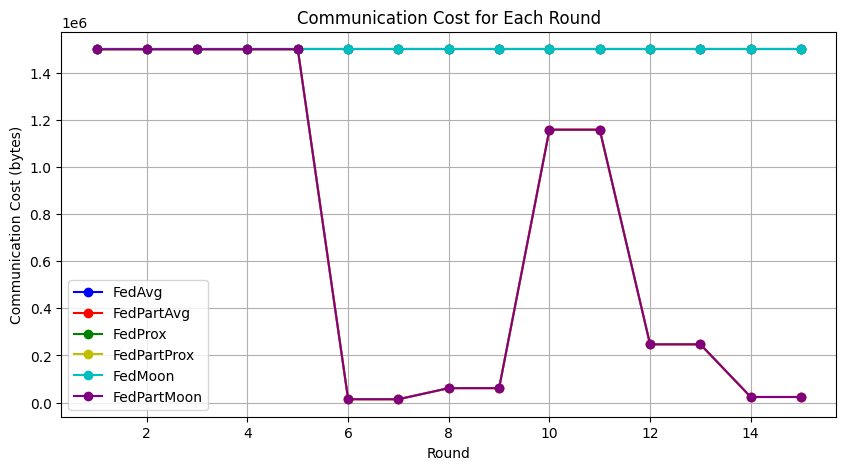

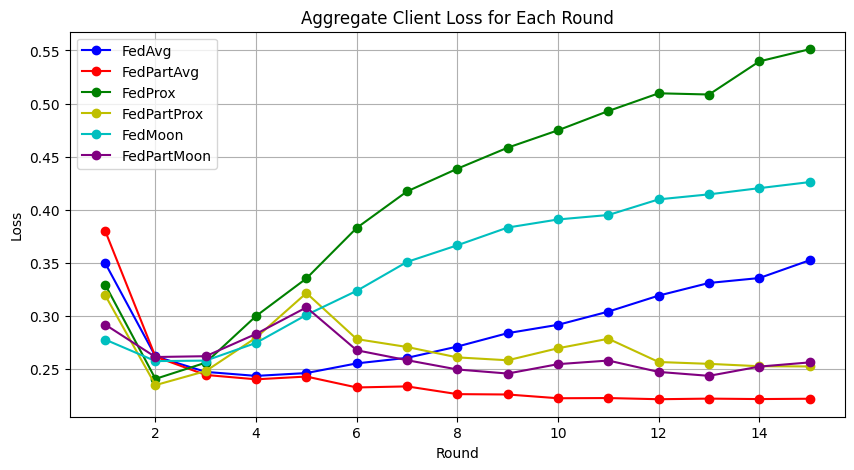

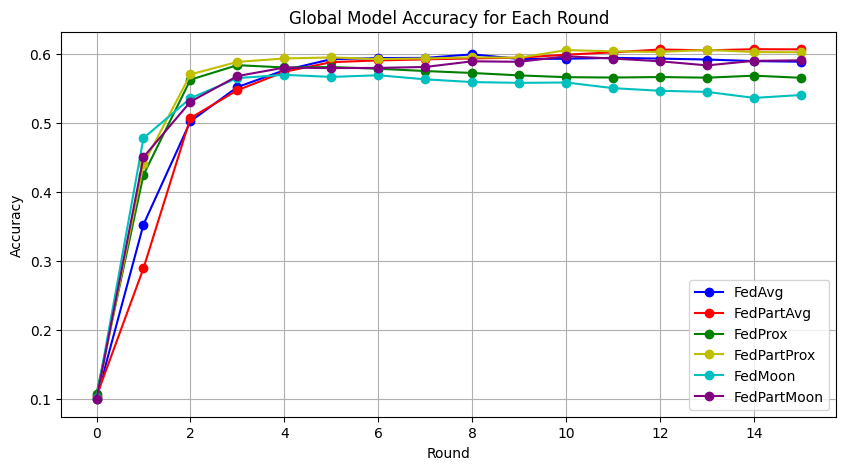

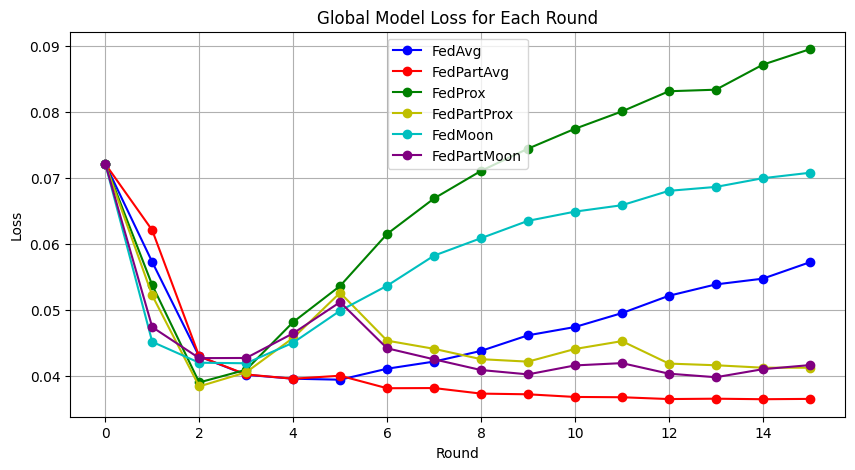

In [31]:
fed_moon_rounds = list(fed_moon_no_freeze_result.keys())
fed_moon_sizes = [fed_moon_no_freeze_result[round]["total_size"] for round in fed_moon_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='b', label='FedAvg')
plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_prox_rounds, fed_prox_sizes, marker='o', linestyle='-', color='g', label='FedProx')
plt.plot(fed_part_prox_rounds, fed_part_prox_sizes, marker='o', linestyle='-', color='y', label='FedPartProx')
plt.plot(fed_moon_rounds, fed_moon_sizes, marker='o', linestyle='-', color='c', label='FedMoon')
plt.plot(fed_part_moon_rounds, fed_part_moon_sizes, marker='o', linestyle='-', color='purple', label='FedPartMoon')
plt.xlabel('Round')
plt.ylabel('Communication Cost (bytes)')
plt.title('Communication Cost for Each Round')
plt.legend()
plt.grid(True)

fed_moon_losses = [fed_moon_no_freeze_result[round]["total_loss"] for round in fed_moon_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='b', label='FedAvg')
plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_prox_rounds, fed_prox_losses, marker='o', linestyle='-', color='g', label='FedProx')
plt.plot(fed_part_prox_rounds, fed_part_prox_losses, marker='o', linestyle='-', color='y', label='FedPartProx')
plt.plot(fed_moon_rounds, fed_moon_losses, marker='o', linestyle='-', color='c', label='FedMoon')
plt.plot(fed_part_moon_rounds, fed_part_moon_losses, marker='o', linestyle='-', color='purple', label='FedPartMoon')

plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Aggregate Client Loss for Each Round')
plt.legend()
plt.grid(True)

fed_moon_model_rounds = list(fed_moon_model_no_freeze_results.keys())
fed_moon_accuracies = [fed_moon_model_no_freeze_results[round]["global_metrics"]["accuracy"] for round in fed_moon_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='b', label='FedAvg')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_prox_model_rounds, fed_prox_accuracies, marker='o', linestyle='-', color='g', label='FedProx')
plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='y', label='FedPartProx')
plt.plot(fed_moon_model_rounds, fed_moon_accuracies, marker='o', linestyle='-', color='c', label='FedMoon')
plt.plot(fed_part_moon_model_rounds, fed_part_moon_accuracies, marker='o', linestyle='-', color='purple', label='FedPartMoon')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Global Model Accuracy for Each Round')
plt.legend()
plt.grid(True)

fed_moon_global_losses = [fed_moon_model_no_freeze_results[round]["global_loss"] for round in fed_moon_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='b', label='FedAvg')
plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
plt.plot(fed_prox_model_rounds, fed_prox_global_losses, marker='o', linestyle='-', color='g', label='FedProx')
plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='y', label='FedPartProx')
plt.plot(fed_moon_model_rounds, fed_moon_global_losses, marker='o', linestyle='-', color='c', label='FedMoon')
plt.plot(fed_part_moon_model_rounds, fed_part_moon_global_losses, marker='o', linestyle='-', color='purple', label='FedPartMoon')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Global Model Loss for Each Round')
plt.legend()
plt.grid(True)
